In [1]:
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import gzip, cPickle

from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa as tsa 
from statsmodels.tsa.stattools import coint

from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLars
from statsmodels.tsa.stattools import adfuller as ADF
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from itertools import combinations
from tqdm import tqdm
import pickle
from datetime import datetime as dt
import math

/app/kaldi/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## This step is to download and load all the ETF data

In [2]:
with gzip.open('ETFs_GSPC_MRP_Production.pkl.gz','r') as f:
    ETFs_GSPC = cPickle.load(f)

In [3]:
All_ETFs = ETFs_GSPC.iloc[:, :-1]

In [4]:
All_ETFs.head(5)

,XLK,VGT,IYW,RYT,IGM,XNTK,PNQI,XLF,VFH,KBE,...,XLU,VPU,IDU,RYU,PUI,VNQ,IYR,RWR,REM,USRT
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,22.098740,53.268589,56.017902,45.235744,54.408684,27.862883,NaN,14.305944,41.652599,35.166389,...,28.566296,59.947933,71.388649,41.737343,14.337612,40.162682,42.196808,47.435150,8.983622,34.976913
2008-01-03,22.132580,52.997772,55.789246,44.755886,54.259819,27.940943,NaN,14.215148,41.288517,35.025986,...,28.525572,60.058559,71.592514,41.917027,14.271438,38.910671,40.830173,46.044064,8.910232,33.672215
2008-01-04,21.269606,50.750046,53.393055,42.910275,51.757092,26.646067,NaN,13.811594,40.147667,33.836712,...,28.742760,59.899540,71.543304,41.633671,14.278792,37.330921,39.534801,44.102032,8.794044,32.376438
2008-01-07,21.083485,50.280647,52.890045,42.310459,51.347736,26.297098,NaN,13.846903,40.333759,34.150543,...,29.340000,60.985104,72.815964,42.158928,14.558186,37.678326,39.903980,44.398148,8.888833,32.447933
2008-01-08,20.525089,48.737019,51.298668,41.396889,49.868423,25.723120,NaN,13.342463,38.836933,32.705246,...,29.346796,60.950520,72.717522,42.158928,14.455253,36.373859,38.453159,42.951958,8.757350,31.482798


In [5]:
GSPC = pd.DataFrame(ETFs_GSPC.iloc[:, -1])

In [6]:
All_ETFs_log = All_ETFs.apply(np.log)
All_ETFs_log.head()

,XLK,VGT,IYW,RYT,IGM,XNTK,PNQI,XLF,VFH,KBE,...,XLU,VPU,IDU,RYU,PUI,VNQ,IYR,RWR,REM,USRT
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,3.095521,3.975347,4.025671,3.811888,3.996524,3.327295,NaN,2.660675,3.729364,3.560091,...,3.352228,4.093476,4.268139,3.731396,2.662886,3.692938,3.742345,3.859364,2.195403,3.554688
2008-01-03,3.097051,3.970250,4.021581,3.801223,3.993784,3.330093,NaN,2.654308,3.720584,3.556090,...,3.350801,4.095320,4.270991,3.735692,2.658260,3.661269,3.709421,3.829599,2.187200,3.516673
2008-01-04,3.057279,3.926913,3.977681,3.759111,3.946561,3.282642,NaN,2.625508,3.692564,3.521546,...,3.358386,4.092669,4.270303,3.728909,2.658775,3.619822,3.677181,3.786506,2.174075,3.477431
2008-01-07,3.048490,3.917620,3.968215,3.745034,3.938621,3.269459,NaN,2.628062,3.697189,3.530778,...,3.378952,4.110630,4.287935,3.741446,2.678153,3.629085,3.686476,3.793198,2.184796,3.479637
2008-01-08,3.021648,3.886439,3.937665,3.723206,3.909388,3.247390,NaN,2.590952,3.659372,3.487535,...,3.379183,4.110062,4.286582,3.741446,2.671058,3.593850,3.649441,3.760082,2.169893,3.449441


In [7]:
All_ETFs_log.drop(['RYF','FTXO','PNQI', 'JHMC','PSCH','PSCI','PSCC','PSCM','XTL','REM','RYF','XLF'], axis=1, inplace=True) # 51Z ETFs left

In [8]:
All_ETFs_log.head()

,XLK,VGT,IYW,RYT,IGM,XNTK,VFH,KBE,IYF,XLY,...,IYZ,XLU,VPU,IDU,RYU,PUI,VNQ,IYR,RWR,USRT
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,3.095521,3.975347,4.025671,3.811888,3.996524,3.327295,3.729364,3.560091,4.342348,3.316239,...,3.080837,3.352228,4.093476,4.268139,3.731396,2.662886,3.692938,3.742345,3.859364,3.554688
2008-01-03,3.097051,3.970250,4.021581,3.801223,3.993784,3.330093,3.720584,3.556090,4.333643,3.304996,...,3.074992,3.350801,4.095320,4.270991,3.735692,2.658260,3.661269,3.709421,3.829599,3.516673
2008-01-04,3.057279,3.926913,3.977681,3.759111,3.946561,3.282642,3.692564,3.521546,4.305491,3.273085,...,3.052323,3.358386,4.092669,4.270303,3.728909,2.658775,3.619822,3.677181,3.786506,3.477431
2008-01-07,3.048490,3.917620,3.968215,3.745034,3.938621,3.269459,3.697189,3.530778,4.309081,3.276646,...,3.063198,3.378952,4.110630,4.287935,3.741446,2.678153,3.629085,3.686476,3.793198,3.479637
2008-01-08,3.021648,3.886439,3.937665,3.723206,3.909388,3.247390,3.659372,3.487535,4.274322,3.257069,...,3.026960,3.379183,4.110062,4.286582,3.741446,2.671058,3.593850,3.649441,3.760082,3.449441


In [9]:
GSPC_log = np.log(GSPC)
GSPC_log.head()

,Adj Close
Date,
2008-01-02,7.277358
2008-01-03,7.277358
2008-01-04,7.252500
2008-01-07,7.255718
2008-01-08,7.237196


## Lasso Alpha finding

In [133]:
j = 0
m = 0
stationary_alpha = []

for i in tqdm(np.arange(0.000001, 0.011, 0.00001)):
    m+=1
    LR_lasso = Lasso(alpha=i, fit_intercept=True,normalize=None,positive=True,random_state =123456)
    LR_lasso.fit(All_ETFs_log_train,GSPC_log_train)
    LR_lasso_residual = GSPC_log_train.values.flatten() - LR_lasso.predict(All_ETFs_log_train)
    if check_for_stationarity_no_print(LR_lasso_residual.flatten(),cutoff=0.05):
        j+= 1
        stationary_alpha.append(LR_lasso.alpha)
        print '\nthe alpha in LASSO is %s and the P-value for ADF is %s'%(i, ADF(LR_lasso_residual.flatten())[1])
        print 'with in all coefficients, there are %s ETFs are positive'%(sum(LR_lasso.coef_>0))
        print 'with in all coefficients, there are %s ETFs are negative'%(sum(LR_lasso.coef_<0))
        print 'with in all coefficients, there are %s ETFs equal to 0'%(sum(LR_lasso.coef_ ==0))

print '\n\ntotal %s LR models are stationary'%(j)
print 'total we tested %s models'%(m)

  0%|          | 2/1100 [00:00<03:26,  5.32it/s]


the alpha in LASSO is 1e-06 and the P-value for ADF is 0.00065451581209
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 39 ETFs equal to 0

the alpha in LASSO is 1.1e-05 and the P-value for ADF is 0.000623154771641
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 39 ETFs equal to 0


  0%|          | 4/1100 [00:00<03:14,  5.62it/s]


the alpha in LASSO is 2.1e-05 and the P-value for ADF is 0.000592634790201
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 39 ETFs equal to 0

the alpha in LASSO is 3.1e-05 and the P-value for ADF is 0.000563165089858
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 39 ETFs equal to 0


  0%|          | 5/1100 [00:00<03:18,  5.51it/s]


the alpha in LASSO is 4.1e-05 and the P-value for ADF is 6.14088740158e-05
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 39 ETFs equal to 0

the alpha in LASSO is 5.1e-05 and the P-value for ADF is 5.63069285667e-05
with in all coefficients, there are 11 ETFs are positive

  1%|          | 7/1100 [00:01<03:21,  5.42it/s]


with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0

the alpha in LASSO is 6.1e-05 and the P-value for ADF is 5.36193779629e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0


  1%|          | 9/1100 [00:01<03:16,  5.57it/s]


the alpha in LASSO is 7.1e-05 and the P-value for ADF is 5.19019155877e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0

the alpha in LASSO is 8.1e-05 and the P-value for ADF is 5.25090736137e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0


  1%|          | 11/1100 [00:01<03:09,  5.73it/s]


the alpha in LASSO is 9.1e-05 and the P-value for ADF is 5.3661081813e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0

the alpha in LASSO is 0.000101 and the P-value for ADF is 5.65295572512e-05
with in all coefficients, there are 9 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 42 ETFs equal to 0


  1%|          | 13/1100 [00:02<03:06,  5.83it/s]


the alpha in LASSO is 0.000111 and the P-value for ADF is 6.0155138912e-05
with in all coefficients, there are 9 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 42 ETFs equal to 0

the alpha in LASSO is 0.000121 and the P-value for ADF is 6.4537948338e-05
with in all coefficients, there are 9 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 42 ETFs equal to 0


  1%|▏         | 15/1100 [00:02<03:02,  5.93it/s]


the alpha in LASSO is 0.000131 and the P-value for ADF is 6.84095573854e-05
with in all coefficients, there are 9 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 42 ETFs equal to 0

the alpha in LASSO is 0.000141 and the P-value for ADF is 7.14644431949e-05
with in all coefficients, there are 9 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 42 ETFs equal to 0


  2%|▏         | 17/1100 [00:02<02:59,  6.02it/s]


the alpha in LASSO is 0.000151 and the P-value for ADF is 6.99953516785e-05
with in all coefficients, there are 9 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 42 ETFs equal to 0

the alpha in LASSO is 0.000161 and the P-value for ADF is 7.05588012565e-05
with in all coefficients, there are 9 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 42 ETFs equal to 0


  2%|▏         | 18/1100 [00:02<02:58,  6.06it/s]


the alpha in LASSO is 0.000171 and the P-value for ADF is 7.28805762418e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0


  2%|▏         | 20/1100 [00:03<03:00,  6.00it/s]


the alpha in LASSO is 0.000181 and the P-value for ADF is 7.57246033794e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0

the alpha in LASSO is 0.000191 and the P-value for ADF is 7.88341870066e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0


  2%|▏         | 22/1100 [00:03<02:57,  6.08it/s]


the alpha in LASSO is 0.000201 and the P-value for ADF is 0.0001210468784
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0

the alpha in LASSO is 0.000211 and the P-value for ADF is 0.00012085867876
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0


  2%|▏         | 24/1100 [00:03<02:58,  6.04it/s]


the alpha in LASSO is 0.000221 and the P-value for ADF is 0.000119930383127
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0

the alpha in LASSO is 0.000231 and the P-value for ADF is 0.000118135958535
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0


  2%|▏         | 26/1100 [00:04<02:58,  6.01it/s]


the alpha in LASSO is 0.000241 and the P-value for ADF is 0.000116034633425
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0

the alpha in LASSO is 0.000251 and the P-value for ADF is 0.000113445485259
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0


  3%|▎         | 28/1100 [00:04<02:56,  6.06it/s]


the alpha in LASSO is 0.000261 and the P-value for ADF is 0.000110370003404
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0

the alpha in LASSO is 0.000271 and the P-value for ADF is 0.000106925187068
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0


  3%|▎         | 30/1100 [00:04<02:56,  6.06it/s]


the alpha in LASSO is 0.000281 and the P-value for ADF is 0.000103215413037
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0

the alpha in LASSO is 0.000291 and the P-value for ADF is 9.93314155228e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0


  3%|▎         | 32/1100 [00:05<02:57,  6.01it/s]


the alpha in LASSO is 0.000301 and the P-value for ADF is 9.53509229996e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0

the alpha in LASSO is 0.000311 and the P-value for ADF is 9.13390988265e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0


  3%|▎         | 34/1100 [00:05<03:02,  5.84it/s]


the alpha in LASSO is 0.000321 and the P-value for ADF is 8.73490955884e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0

the alpha in LASSO is 0.000331 and the P-value for ADF is 8.342322104e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0


  3%|▎         | 36/1100 [00:06<03:00,  5.90it/s]


the alpha in LASSO is 0.000341 and the P-value for ADF is 7.95942311986e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0

the alpha in LASSO is 0.000351 and the P-value for ADF is 7.58866853794e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0


  3%|▎         | 38/1100 [00:06<02:58,  5.94it/s]


the alpha in LASSO is 0.000361 and the P-value for ADF is 7.23336786369e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0

the alpha in LASSO is 0.000371 and the P-value for ADF is 6.88146768159e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0


  4%|▎         | 40/1100 [00:06<02:57,  5.97it/s]


the alpha in LASSO is 0.000381 and the P-value for ADF is 6.54634880526e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0

the alpha in LASSO is 0.000391 and the P-value for ADF is 6.2273021798e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0


  4%|▍         | 42/1100 [00:06<02:56,  6.01it/s]


the alpha in LASSO is 0.000401 and the P-value for ADF is 5.92569536992e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0

the alpha in LASSO is 0.000411 and the P-value for ADF is 5.71119406149e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0


  4%|▍         | 44/1100 [00:07<02:54,  6.06it/s]


the alpha in LASSO is 0.000421 and the P-value for ADF is 5.5182154206e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0

the alpha in LASSO is 0.000431 and the P-value for ADF is 5.48097201825e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0


  4%|▍         | 46/1100 [00:07<02:52,  6.11it/s]


the alpha in LASSO is 0.000441 and the P-value for ADF is 5.48723423667e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0

the alpha in LASSO is 0.000451 and the P-value for ADF is 5.4727541939e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0


  4%|▍         | 48/1100 [00:07<02:50,  6.17it/s]


the alpha in LASSO is 0.000461 and the P-value for ADF is 5.45557913148e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0

the alpha in LASSO is 0.000471 and the P-value for ADF is 5.44011518429e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0


  5%|▍         | 50/1100 [00:08<02:49,  6.21it/s]


the alpha in LASSO is 0.000481 and the P-value for ADF is 5.42447315298e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0

the alpha in LASSO is 0.000491 and the P-value for ADF is 5.41330781952e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0


  5%|▍         | 52/1100 [00:08<02:48,  6.23it/s]


the alpha in LASSO is 0.000501 and the P-value for ADF is 5.39958395599e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0

the alpha in LASSO is 0.000511 and the P-value for ADF is 5.39485116503e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0


  5%|▍         | 54/1100 [00:08<02:46,  6.26it/s]


the alpha in LASSO is 0.000521 and the P-value for ADF is 5.39181592931e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0

the alpha in LASSO is 0.000531 and the P-value for ADF is 5.39051449143e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0


  5%|▌         | 56/1100 [00:08<02:45,  6.31it/s]


the alpha in LASSO is 0.000541 and the P-value for ADF is 5.39083973788e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0

the alpha in LASSO is 0.000551 and the P-value for ADF is 5.39259324597e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0


  5%|▌         | 58/1100 [00:09<02:44,  6.34it/s]


the alpha in LASSO is 0.000561 and the P-value for ADF is 5.39563335996e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0

the alpha in LASSO is 0.000571 and the P-value for ADF is 5.39996404928e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0


  5%|▌         | 60/1100 [00:09<02:43,  6.37it/s]


the alpha in LASSO is 0.000581 and the P-value for ADF is 5.40541081232e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0

the alpha in LASSO is 0.000591 and the P-value for ADF is 5.41183831028e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0


  6%|▌         | 62/1100 [00:09<02:42,  6.41it/s]


the alpha in LASSO is 0.000601 and the P-value for ADF is 5.41921000372e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0

the alpha in LASSO is 0.000611 and the P-value for ADF is 5.42690989246e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0


  6%|▌         | 64/1100 [00:09<02:40,  6.44it/s]


the alpha in LASSO is 0.000621 and the P-value for ADF is 5.43678410787e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0

the alpha in LASSO is 0.000631 and the P-value for ADF is 5.44561317173e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0


  6%|▌         | 66/1100 [00:10<02:39,  6.47it/s]


the alpha in LASSO is 0.000641 and the P-value for ADF is 5.45487174659e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0

the alpha in LASSO is 0.000651 and the P-value for ADF is 5.46472544043e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0


  6%|▌         | 68/1100 [00:10<02:39,  6.48it/s]


the alpha in LASSO is 0.000661 and the P-value for ADF is 5.47515282064e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0

the alpha in LASSO is 0.000671 and the P-value for ADF is 5.48771136086e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0


  6%|▋         | 70/1100 [00:10<02:38,  6.51it/s]


the alpha in LASSO is 0.000681 and the P-value for ADF is 5.49915681663e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0

the alpha in LASSO is 0.000691 and the P-value for ADF is 5.51110128896e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0


  7%|▋         | 72/1100 [00:11<02:37,  6.51it/s]


the alpha in LASSO is 0.000701 and the P-value for ADF is 5.45899741098e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0

the alpha in LASSO is 0.000711 and the P-value for ADF is 5.46721279655e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0


  7%|▋         | 74/1100 [00:11<02:37,  6.52it/s]


the alpha in LASSO is 0.000721 and the P-value for ADF is 5.48014774526e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0

the alpha in LASSO is 0.000731 and the P-value for ADF is 5.49560820089e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0


  7%|▋         | 76/1100 [00:11<02:36,  6.53it/s]


the alpha in LASSO is 0.000741 and the P-value for ADF is 5.50919203584e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 40 ETFs equal to 0

the alpha in LASSO is 0.000751 and the P-value for ADF is 5.52005373677e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0


  7%|▋         | 78/1100 [00:11<02:35,  6.56it/s]


the alpha in LASSO is 0.000761 and the P-value for ADF is 5.54146153709e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0

the alpha in LASSO is 0.000771 and the P-value for ADF is 5.59176838189e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0


  7%|▋         | 80/1100 [00:12<02:35,  6.57it/s]


the alpha in LASSO is 0.000781 and the P-value for ADF is 5.64488421308e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0

the alpha in LASSO is 0.000791 and the P-value for ADF is 5.66910056538e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0


  7%|▋         | 82/1100 [00:12<02:34,  6.59it/s]


the alpha in LASSO is 0.000801 and the P-value for ADF is 5.6963173673e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0

the alpha in LASSO is 0.000811 and the P-value for ADF is 5.7246618251e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0


  8%|▊         | 84/1100 [00:12<02:33,  6.61it/s]


the alpha in LASSO is 0.000821 and the P-value for ADF is 5.75192488449e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0

the alpha in LASSO is 0.000831 and the P-value for ADF is 5.78110514632e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0


  8%|▊         | 86/1100 [00:12<02:32,  6.63it/s]


the alpha in LASSO is 0.000841 and the P-value for ADF is 5.81044879635e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0

the alpha in LASSO is 0.000851 and the P-value for ADF is 5.83998737053e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0


  8%|▊         | 87/1100 [00:13<02:32,  6.64it/s]


the alpha in LASSO is 0.000861 and the P-value for ADF is 5.86961859847e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0


  8%|▊         | 89/1100 [00:13<02:32,  6.63it/s]


the alpha in LASSO is 0.000871 and the P-value for ADF is 5.89924065696e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0

the alpha in LASSO is 0.000881 and the P-value for ADF is 5.92895036547e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0


  8%|▊         | 91/1100 [00:13<02:31,  6.65it/s]


the alpha in LASSO is 0.000891 and the P-value for ADF is 5.95862993696e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0

the alpha in LASSO is 0.000901 and the P-value for ADF is 5.98825630623e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0


  8%|▊         | 93/1100 [00:13<02:30,  6.67it/s]


the alpha in LASSO is 0.000911 and the P-value for ADF is 6.01792955214e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0

the alpha in LASSO is 0.000921 and the P-value for ADF is 6.04756545641e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0


  9%|▊         | 95/1100 [00:14<02:30,  6.69it/s]


the alpha in LASSO is 0.000931 and the P-value for ADF is 0.00586999299833
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0

the alpha in LASSO is 0.000941 and the P-value for ADF is 0.0059440296257
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0


  9%|▉         | 97/1100 [00:14<02:29,  6.70it/s]


the alpha in LASSO is 0.000951 and the P-value for ADF is 0.00601658505008
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 41 ETFs equal to 0

the alpha in LASSO is 0.000961 and the P-value for ADF is 0.00610407844278
with in all coefficients, there are 9 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 42 ETFs equal to 0


  9%|▉         | 99/1100 [00:14<02:29,  6.70it/s]


the alpha in LASSO is 0.000971 and the P-value for ADF is 0.00624943694472
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0

the alpha in LASSO is 0.000981 and the P-value for ADF is 0.00640786565346
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0


  9%|▉         | 101/1100 [00:15<02:29,  6.69it/s]


the alpha in LASSO is 0.000991 and the P-value for ADF is 0.00657173036337
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0

the alpha in LASSO is 0.001001 and the P-value for ADF is 0.00673924023047
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0


  9%|▉         | 103/1100 [00:15<02:29,  6.68it/s]


the alpha in LASSO is 0.001011 and the P-value for ADF is 0.0069082761823
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0

the alpha in LASSO is 0.001021 and the P-value for ADF is 0.0070831798214
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0


 10%|▉         | 105/1100 [00:15<02:29,  6.67it/s]


the alpha in LASSO is 0.001031 and the P-value for ADF is 0.00725952439271
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0

the alpha in LASSO is 0.001041 and the P-value for ADF is 0.00743962662617
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0


 10%|▉         | 107/1100 [00:15<02:28,  6.69it/s]


the alpha in LASSO is 0.001051 and the P-value for ADF is 0.00762093460035
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0

the alpha in LASSO is 0.001061 and the P-value for ADF is 0.00780853650899
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0


 10%|▉         | 109/1100 [00:16<02:27,  6.71it/s]


the alpha in LASSO is 0.001071 and the P-value for ADF is 0.00799467458843
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0

the alpha in LASSO is 0.001081 and the P-value for ADF is 0.00817879288173
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0


 10%|█         | 111/1100 [00:16<02:27,  6.71it/s]


the alpha in LASSO is 0.001091 and the P-value for ADF is 0.0083600964485
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0

the alpha in LASSO is 0.001101 and the P-value for ADF is 0.00849194865503
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0


 10%|█         | 113/1100 [00:16<02:26,  6.72it/s]


the alpha in LASSO is 0.001111 and the P-value for ADF is 0.00868318496272
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0

the alpha in LASSO is 0.001121 and the P-value for ADF is 0.00887813583284
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0


 10%|█         | 115/1100 [00:17<02:26,  6.74it/s]


the alpha in LASSO is 0.001131 and the P-value for ADF is 0.00907585458596
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0

the alpha in LASSO is 0.001141 and the P-value for ADF is 0.00927633189562
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0


 11%|█         | 117/1100 [00:17<02:25,  6.75it/s]


the alpha in LASSO is 0.001151 and the P-value for ADF is 0.00948009116241
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0

the alpha in LASSO is 0.001161 and the P-value for ADF is 0.00968656234228
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0


 11%|█         | 119/1100 [00:17<02:25,  6.75it/s]


the alpha in LASSO is 0.001171 and the P-value for ADF is 0.00989635184856
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0

the alpha in LASSO is 0.001181 and the P-value for ADF is 0.0101088980587
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0


 11%|█         | 121/1100 [00:17<02:24,  6.76it/s]


the alpha in LASSO is 0.001191 and the P-value for ADF is 0.0103241923205
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0

the alpha in LASSO is 0.001201 and the P-value for ADF is 0.0105422300571
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0


 11%|█         | 123/1100 [00:18<02:24,  6.77it/s]


the alpha in LASSO is 0.001211 and the P-value for ADF is 0.0107630116917
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0

the alpha in LASSO is 0.001221 and the P-value for ADF is 0.0109864727557
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0


 11%|█▏        | 125/1100 [00:18<02:24,  6.77it/s]


the alpha in LASSO is 0.001231 and the P-value for ADF is 0.0112125833491
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0

the alpha in LASSO is 0.001241 and the P-value for ADF is 0.0114420413055
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0


 12%|█▏        | 127/1100 [00:18<02:23,  6.77it/s]


the alpha in LASSO is 0.001251 and the P-value for ADF is 0.0116734617523
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0

the alpha in LASSO is 0.001261 and the P-value for ADF is 0.0119082213959
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0


 12%|█▏        | 129/1100 [00:19<02:23,  6.78it/s]


the alpha in LASSO is 0.001271 and the P-value for ADF is 0.012144863254
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0

the alpha in LASSO is 0.001281 and the P-value for ADF is 0.0123848336102
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0


 12%|█▏        | 131/1100 [00:19<02:22,  6.79it/s]


the alpha in LASSO is 0.001291 and the P-value for ADF is 0.0126266004178
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0

the alpha in LASSO is 0.001301 and the P-value for ADF is 0.0128716820304
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0


 12%|█▏        | 133/1100 [00:19<02:22,  6.79it/s]


the alpha in LASSO is 0.001311 and the P-value for ADF is 0.0131184712871
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0

the alpha in LASSO is 0.001321 and the P-value for ADF is 0.0133685142549
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0


 12%|█▏        | 135/1100 [00:19<02:21,  6.80it/s]


the alpha in LASSO is 0.001331 and the P-value for ADF is 0.0136210165942
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0

the alpha in LASSO is 0.001341 and the P-value for ADF is 0.0138759962797
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0


 12%|█▏        | 136/1100 [00:20<02:22,  6.78it/s]


the alpha in LASSO is 0.001351 and the P-value for ADF is 0.014132500647
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0

the alpha in LASSO is 0.001361 and the P-value for ADF is 0.0143922630218

 13%|█▎        | 139/1100 [00:20<02:22,  6.73it/s]


with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0

the alpha in LASSO is 0.001371 and the P-value for ADF is 0.0146543748184
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 43 ETFs equal to 0

the alpha in LASSO is 0.001381 and the P-value for ADF is 0.0150263434783
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 13%|█▎        | 141/1100 [00:20<02:22,  6.74it/s]


the alpha in LASSO is 0.001391 and the P-value for ADF is 0.0154094491775
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001401 and the P-value for ADF is 0.0157585664372
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 13%|█▎        | 143/1100 [00:21<02:21,  6.75it/s]


the alpha in LASSO is 0.001411 and the P-value for ADF is 0.0161329968806
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001421 and the P-value for ADF is 0.0165201897937
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 13%|█▎        | 145/1100 [00:21<02:21,  6.77it/s]


the alpha in LASSO is 0.001431 and the P-value for ADF is 0.0169153101254
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001441 and the P-value for ADF is 0.0173177887623
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 13%|█▎        | 147/1100 [00:21<02:20,  6.78it/s]


the alpha in LASSO is 0.001451 and the P-value for ADF is 0.0177279228563
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001461 and the P-value for ADF is 0.0181446990829
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 14%|█▎        | 149/1100 [00:21<02:20,  6.79it/s]


the alpha in LASSO is 0.001471 and the P-value for ADF is 0.0185689484956
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001481 and the P-value for ADF is 0.0190006684156
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 14%|█▎        | 151/1100 [00:22<02:19,  6.80it/s]


the alpha in LASSO is 0.001491 and the P-value for ADF is 0.019439030101
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001501 and the P-value for ADF is 0.019885731256
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 14%|█▍        | 153/1100 [00:22<02:18,  6.81it/s]


the alpha in LASSO is 0.001511 and the P-value for ADF is 0.0203399454025
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001521 and the P-value for ADF is 0.0208008771755
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 14%|█▍        | 155/1100 [00:22<02:18,  6.83it/s]


the alpha in LASSO is 0.001531 and the P-value for ADF is 0.0212693845666
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001541 and the P-value for ADF is 0.021746277605
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 14%|█▍        | 157/1100 [00:22<02:17,  6.84it/s]


the alpha in LASSO is 0.001551 and the P-value for ADF is 0.0222299981303
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001561 and the P-value for ADF is 0.0227213747544
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 14%|█▍        | 159/1100 [00:23<02:17,  6.85it/s]


the alpha in LASSO is 0.001571 and the P-value for ADF is 0.0232211878832
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001581 and the P-value for ADF is 0.0237279360412
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 15%|█▍        | 161/1100 [00:23<02:17,  6.85it/s]


the alpha in LASSO is 0.001591 and the P-value for ADF is 0.0242424087298
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001601 and the P-value for ADF is 0.0247653349727
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 15%|█▍        | 163/1100 [00:23<02:16,  6.86it/s]


the alpha in LASSO is 0.001611 and the P-value for ADF is 0.0252952960318
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001621 and the P-value for ADF is 0.0258330331939
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 15%|█▌        | 165/1100 [00:23<02:15,  6.88it/s]


the alpha in LASSO is 0.001631 and the P-value for ADF is 0.0263792251997
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001641 and the P-value for ADF is 0.0269325625737
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 15%|█▌        | 167/1100 [00:24<02:15,  6.89it/s]


the alpha in LASSO is 0.001651 and the P-value for ADF is 0.0274943357139
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001661 and the P-value for ADF is 0.0280632852587
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 15%|█▌        | 169/1100 [00:24<02:14,  6.90it/s]


the alpha in LASSO is 0.001671 and the P-value for ADF is 0.0286406568603
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001681 and the P-value for ADF is 0.0292252683201
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 16%|█▌        | 171/1100 [00:24<02:14,  6.91it/s]


the alpha in LASSO is 0.001691 and the P-value for ADF is 0.0298182680632
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001701 and the P-value for ADF is 0.0304185554185
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 16%|█▌        | 173/1100 [00:25<02:14,  6.90it/s]


the alpha in LASSO is 0.001711 and the P-value for ADF is 0.031027189476
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001721 and the P-value for ADF is 0.0316436281973
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 16%|█▌        | 175/1100 [00:25<02:14,  6.88it/s]


the alpha in LASSO is 0.001731 and the P-value for ADF is 0.0322678653054
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001741 and the P-value for ADF is 0.032899894301
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 16%|█▌        | 177/1100 [00:25<02:14,  6.86it/s]


the alpha in LASSO is 0.001751 and the P-value for ADF is 0.0335397092793
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001761 and the P-value for ADF is 0.0341873034731
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 16%|█▋        | 179/1100 [00:26<02:14,  6.85it/s]


the alpha in LASSO is 0.001771 and the P-value for ADF is 0.0348426675112
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001781 and the P-value for ADF is 0.0355061023461
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 16%|█▋        | 181/1100 [00:26<02:14,  6.84it/s]


the alpha in LASSO is 0.001791 and the P-value for ADF is 0.0361769360811
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001801 and the P-value for ADF is 0.0368557644268
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 17%|█▋        | 183/1100 [00:26<02:14,  6.84it/s]


the alpha in LASSO is 0.001811 and the P-value for ADF is 0.0375424806363
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001821 and the P-value for ADF is 0.0382365819237
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 17%|█▋        | 185/1100 [00:26<02:13,  6.85it/s]


the alpha in LASSO is 0.001831 and the P-value for ADF is 0.0389384834195
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001841 and the P-value for ADF is 0.0396479394277
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 17%|█▋        | 187/1100 [00:27<02:12,  6.87it/s]


the alpha in LASSO is 0.001851 and the P-value for ADF is 0.0403650570917
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001861 and the P-value for ADF is 0.0410898573024
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 17%|█▋        | 189/1100 [00:27<02:12,  6.88it/s]


the alpha in LASSO is 0.001871 and the P-value for ADF is 0.0418218845706
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001881 and the P-value for ADF is 0.0425613312253
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 17%|█▋        | 191/1100 [00:27<02:11,  6.89it/s]


the alpha in LASSO is 0.001891 and the P-value for ADF is 0.0433083044173
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001901 and the P-value for ADF is 0.0440628525994
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 18%|█▊        | 193/1100 [00:27<02:11,  6.91it/s]


the alpha in LASSO is 0.001911 and the P-value for ADF is 0.0448249940436
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001921 and the P-value for ADF is 0.0455946980992
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 18%|█▊        | 195/1100 [00:28<02:10,  6.92it/s]


the alpha in LASSO is 0.001931 and the P-value for ADF is 0.0463716494079
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001941 and the P-value for ADF is 0.0471563453957
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 18%|█▊        | 197/1100 [00:28<02:10,  6.93it/s]


the alpha in LASSO is 0.001951 and the P-value for ADF is 0.0479486740176
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.001961 and the P-value for ADF is 0.0487486460486
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 18%|█▊        | 200/1100 [00:28<02:09,  6.97it/s]


the alpha in LASSO is 0.001971 and the P-value for ADF is 0.0495561821053
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 19%|█▊        | 206/1100 [00:29<02:06,  7.06it/s]


the alpha in LASSO is 0.002051 and the P-value for ADF is 0.00153246715713
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002061 and the P-value for ADF is 0.00156571501877
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 19%|█▉        | 208/1100 [00:29<02:06,  7.06it/s]


the alpha in LASSO is 0.002071 and the P-value for ADF is 0.00159949975245
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002081 and the P-value for ADF is 0.00163388625377
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 19%|█▉        | 211/1100 [00:29<02:05,  7.06it/s]


the alpha in LASSO is 0.002091 and the P-value for ADF is 0.00166892904514
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002101 and the P-value for ADF is 0.00170453128169
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 19%|█▉        | 213/1100 [00:30<02:05,  7.07it/s]


the alpha in LASSO is 0.002111 and the P-value for ADF is 0.00174074808454
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002121 and the P-value for ADF is 0.00177763079584
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 20%|█▉        | 215/1100 [00:30<02:04,  7.09it/s]


the alpha in LASSO is 0.002131 and the P-value for ADF is 0.00181509876474
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002141 and the P-value for ADF is 0.00185324093288
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 20%|█▉        | 217/1100 [00:30<02:04,  7.10it/s]


the alpha in LASSO is 0.002151 and the P-value for ADF is 0.00189198728294
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002161 and the P-value for ADF is 0.00193138210332
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 20%|█▉        | 219/1100 [00:30<02:04,  7.10it/s]


the alpha in LASSO is 0.002171 and the P-value for ADF is 0.00197146062081
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002181 and the P-value for ADF is 0.00201217336602
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 20%|██        | 221/1100 [00:31<02:03,  7.12it/s]


the alpha in LASSO is 0.002191 and the P-value for ADF is 0.00205357334909
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002201 and the P-value for ADF is 0.00209562661783
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 20%|██        | 223/1100 [00:31<02:03,  7.13it/s]


the alpha in LASSO is 0.002211 and the P-value for ADF is 0.00213836319857
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002221 and the P-value for ADF is 0.0021817946114
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 20%|██        | 225/1100 [00:31<02:02,  7.14it/s]


the alpha in LASSO is 0.002231 and the P-value for ADF is 0.00222591978442
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002241 and the P-value for ADF is 0.00227074053441
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 21%|██        | 227/1100 [00:31<02:02,  7.15it/s]


the alpha in LASSO is 0.002251 and the P-value for ADF is 0.00231627143402
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002261 and the P-value for ADF is 0.00236249864098
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 21%|██        | 229/1100 [00:31<02:01,  7.16it/s]


the alpha in LASSO is 0.002271 and the P-value for ADF is 0.002409454586
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002281 and the P-value for ADF is 0.00245710360132
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 21%|██        | 231/1100 [00:32<02:01,  7.17it/s]


the alpha in LASSO is 0.002291 and the P-value for ADF is 0.00250551575214
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002301 and the P-value for ADF is 0.00255467139532
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 21%|██        | 233/1100 [00:32<02:00,  7.18it/s]


the alpha in LASSO is 0.002311 and the P-value for ADF is 0.00260452313448
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002321 and the P-value for ADF is 0.0026551804471
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 21%|██▏       | 235/1100 [00:32<02:00,  7.19it/s]


the alpha in LASSO is 0.002331 and the P-value for ADF is 0.00270652712708
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002341 and the P-value for ADF is 0.00275870516355
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 22%|██▏       | 237/1100 [00:32<01:59,  7.20it/s]


the alpha in LASSO is 0.002351 and the P-value for ADF is 0.00281155861836
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002361 and the P-value for ADF is 0.00286527098551
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 22%|██▏       | 239/1100 [00:33<01:59,  7.21it/s]


the alpha in LASSO is 0.002371 and the P-value for ADF is 0.00291976470733
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002381 and the P-value for ADF is 0.00297493579526
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 22%|██▏       | 241/1100 [00:33<01:58,  7.22it/s]


the alpha in LASSO is 0.002391 and the P-value for ADF is 0.00303101818665
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002401 and the P-value for ADF is 0.00308775427283
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 22%|██▏       | 243/1100 [00:33<01:58,  7.23it/s]


the alpha in LASSO is 0.002411 and the P-value for ADF is 0.00314543472767
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002421 and the P-value for ADF is 0.00320393180013
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 22%|██▏       | 245/1100 [00:33<01:58,  7.22it/s]


the alpha in LASSO is 0.002431 and the P-value for ADF is 0.00326305722589
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002441 and the P-value for ADF is 0.00332318793934
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 22%|██▏       | 247/1100 [00:34<01:57,  7.23it/s]


the alpha in LASSO is 0.002451 and the P-value for ADF is 0.00338392936704
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002461 and the P-value for ADF is 0.00344571672836
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 23%|██▎       | 249/1100 [00:34<01:57,  7.24it/s]


the alpha in LASSO is 0.002471 and the P-value for ADF is 0.0035083506026
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002481 and the P-value for ADF is 0.0035715634615
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 23%|██▎       | 251/1100 [00:34<01:57,  7.25it/s]


the alpha in LASSO is 0.002491 and the P-value for ADF is 0.00363587023429
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002501 and the P-value for ADF is 0.00370042376571
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 23%|██▎       | 253/1100 [00:34<01:56,  7.25it/s]


the alpha in LASSO is 0.002511 and the P-value for ADF is 0.00376515464447
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002521 and the P-value for ADF is 0.00383065202487
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 23%|██▎       | 254/1100 [00:35<01:56,  7.25it/s]


the alpha in LASSO is 0.002531 and the P-value for ADF is 0.00389725348537
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 23%|██▎       | 256/1100 [00:35<01:57,  7.21it/s]


the alpha in LASSO is 0.002541 and the P-value for ADF is 0.00396431644205
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0

the alpha in LASSO is 0.002551 and the P-value for ADF is 0.00403215075013
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 44 ETFs equal to 0


 39%|███▉      | 428/1100 [00:47<01:13,  9.10it/s]


the alpha in LASSO is 0.004261 and the P-value for ADF is 0.0292437202514
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004271 and the P-value for ADF is 0.0295503096009
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004281 and the P-value for ADF is 0.0298602684937
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0


 39%|███▉      | 430/1100 [00:47<01:13,  9.11it/s]


the alpha in LASSO is 0.004291 and the P-value for ADF is 0.030172157833
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004301 and the P-value for ADF is 0.0304844344466
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0


 39%|███▉      | 432/1100 [00:47<01:13,  9.11it/s]


the alpha in LASSO is 0.004311 and the P-value for ADF is 0.0308001387086
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004321 and the P-value for ADF is 0.0311177396375
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004331 and the P-value for ADF is 0.0314372471278

 40%|███▉      | 436/1100 [00:47<01:12,  9.11it/s]


with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004341 and the P-value for ADF is 0.0317570400951
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004351 and the P-value for ADF is 0.0320803268651
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0


 40%|███▉      | 438/1100 [00:48<01:12,  9.11it/s]


the alpha in LASSO is 0.004361 and the P-value for ADF is 0.0324055115545
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004371 and the P-value for ADF is 0.0327308922858
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004381 and the P-value for ADF is 0.033059835748
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0


 40%|████      | 441/1100 [00:48<01:12,  9.11it/s]


the alpha in LASSO is 0.004391 and the P-value for ADF is 0.033390664417
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004401 and the P-value for ADF is 0.0337233564617
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0


 40%|████      | 443/1100 [00:48<01:12,  9.10it/s]


the alpha in LASSO is 0.004411 and the P-value for ADF is 0.0340561675536
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004421 and the P-value for ADF is 0.0343926054709
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0


 40%|████      | 445/1100 [00:48<01:12,  9.09it/s]


the alpha in LASSO is 0.004431 and the P-value for ADF is 0.0347308976596
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004441 and the P-value for ADF is 0.0350710571892
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0


 41%|████      | 446/1100 [00:49<01:11,  9.09it/s]


the alpha in LASSO is 0.004451 and the P-value for ADF is 0.0354112274431
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004461 and the P-value for ADF is 0.0357550820983
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004471 and the P-value for ADF is 0.0361007912246

 41%|████      | 450/1100 [00:49<01:11,  9.09it/s]


with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004481 and the P-value for ADF is 0.0364483417229
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004491 and the P-value for ADF is 0.0367957896375
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0


 41%|████      | 452/1100 [00:49<01:11,  9.10it/s]


the alpha in LASSO is 0.004501 and the P-value for ADF is 0.0371470072012
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004511 and the P-value for ADF is 0.0375000517608
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004521 and the P-value for ADF is 0.0378549117702

 41%|████▏     | 455/1100 [00:50<01:10,  9.10it/s]


with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004531 and the P-value for ADF is 0.0382095706477
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004541 and the P-value for ADF is 0.0385680295058
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0


 41%|████▏     | 456/1100 [00:50<01:10,  9.09it/s]


the alpha in LASSO is 0.004551 and the P-value for ADF is 0.0389282857785
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004561 and the P-value for ADF is 0.0392903508704

 42%|████▏     | 460/1100 [00:50<01:10,  9.08it/s]


with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004571 and the P-value for ADF is 0.0396520953672
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004581 and the P-value for ADF is 0.0400177334891
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004591 and the P-value for ADF is 0.0403851637761
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0


 42%|████▏     | 462/1100 [00:50<01:10,  9.08it/s]


the alpha in LASSO is 0.004601 and the P-value for ADF is 0.0407521566162
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004611 and the P-value for ADF is 0.0411231337876
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0


 42%|████▏     | 464/1100 [00:51<01:10,  9.08it/s]


the alpha in LASSO is 0.004621 and the P-value for ADF is 0.0414958773903
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004631 and the P-value for ADF is 0.041870390697
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004641 and the P-value for ADF is 0.0422443272252

 42%|████▏     | 467/1100 [00:51<01:09,  9.08it/s]


with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004651 and the P-value for ADF is 0.0426223299581
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004661 and the P-value for ADF is 0.0430020832599
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0


 43%|████▎     | 470/1100 [00:51<01:09,  9.09it/s]


the alpha in LASSO is 0.004671 and the P-value for ADF is 0.0433835798207
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004681 and the P-value for ADF is 0.0437643457038
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004691 and the P-value for ADF is 0.0441492798072
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0


 43%|████▎     | 472/1100 [00:51<01:09,  9.09it/s]


the alpha in LASSO is 0.004701 and the P-value for ADF is 0.0445359387722
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004711 and the P-value for ADF is 0.0449243082845
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0


 43%|████▎     | 475/1100 [00:52<01:08,  9.09it/s]


the alpha in LASSO is 0.004721 and the P-value for ADF is 0.0453118035072
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004731 and the P-value for ADF is 0.0457035642732
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004741 and the P-value for ADF is 0.0460970228017
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0


 43%|████▎     | 477/1100 [00:52<01:08,  9.09it/s]


the alpha in LASSO is 0.004751 and the P-value for ADF is 0.0464921524373
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004761 and the P-value for ADF is 0.0468862671777
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0


 44%|████▎     | 479/1100 [00:52<01:08,  9.09it/s]


the alpha in LASSO is 0.004771 and the P-value for ADF is 0.0472847433507
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004781 and the P-value for ADF is 0.0476848875084
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004791 and the P-value for ADF is 0.0480866653937

 44%|████▍     | 483/1100 [00:53<01:07,  9.10it/s]


with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004801 and the P-value for ADF is 0.0484900975643
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004811 and the P-value for ADF is 0.0488923539026
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0

the alpha in LASSO is 0.004821 and the P-value for ADF is 0.0492990591543
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0


 44%|████▍     | 487/1100 [00:53<01:07,  9.12it/s]


the alpha in LASSO is 0.004831 and the P-value for ADF is 0.0497073759113
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 46 ETFs equal to 0


100%|██████████| 1100/1100 [01:34<00:00, 11.68it/s]



total 307 LR models are stationary
total we tested 1100 models


In [238]:
GSPC_log_train_fun = GSPC_log.loc["2008": "2013"].copy()
All_ETFs_log_train_fun = All_ETFs_log.loc["2008": "2013"].copy()

LR_lasso = Lasso(alpha=0.000101, fit_intercept=True,normalize=None,positive=True,random_state =123456)
LR_lasso.fit(All_ETFs_log_train_fun,GSPC_log_train_fun)
LR_lasso_residual = GSPC_log_train_fun.values.flatten() - LR_lasso.predict(All_ETFs_log_train_fun)
print '\nthe alpha in LASSO is %s and the P-value for ADF is %s'%(0.000101, ADF(LR_lasso_residual.flatten())[1])
print 'with in all coefficients, there are %s ETFs are positive'%(sum(LR_lasso.coef_>0))
print 'with in all coefficients, there are %s ETFs are negative'%(sum(LR_lasso.coef_<0))
print 'with in all coefficients, there are %s ETFs equal to 0'%(sum(LR_lasso.coef_ ==0))


All_ETFs_log_train_fun.loc[:,LR_lasso.coef_>0].head(2)


the alpha in LASSO is 0.000101 and the P-value for ADF is 5.65295572512e-05
with in all coefficients, there are 9 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 42 ETFs equal to 0


,XLK,IYF,XLV,IBB,XLI,VIS,XLE,IYE,XLU
Date,,,,,,,,,
2008-01-02,3.095521,4.342348,3.372757,3.272472,3.430769,4.095256,4.157497,3.633426,3.352228
2008-01-03,3.097051,4.333643,3.378749,3.277166,3.431548,4.097615,4.169252,3.639774,3.350801


In [239]:
portfolio_test_fun = pd.DataFrame(0,columns=['portf_forest','Daily_Return'] ,index=GSPC_log.loc['2014':'2017'].index)  # this is to store the test data from ETFs
index_of_etfs = LR_lasso.coef_ > 0
coefficients= LR_lasso.coef_.copy()
nonzero_coeff  = coefficients[~(coefficients==0)].copy()
nonzero_coeff = nonzero_coeff/nonzero_coeff.sum()
All_ETFs_log_fun = All_ETFs_log.loc[: , index_of_etfs] .copy()  # this contains all the etfs we used to build portfolio
portfolio_test_fun['portf_forest'] = All_ETFs_log_fun.dot(nonzero_coeff).copy()
portfolio_test_fun['Daily_Return'] = portfolio_test_fun['portf_forest'].diff()
portfolio_test_fun['Cumsum Daily_Return'] = portfolio_test_fun['Daily_Return'].cumsum()
portfolio_test_fun.iloc[0,1] = 0

Correlation is 0.987699
Correlation is 0.985569


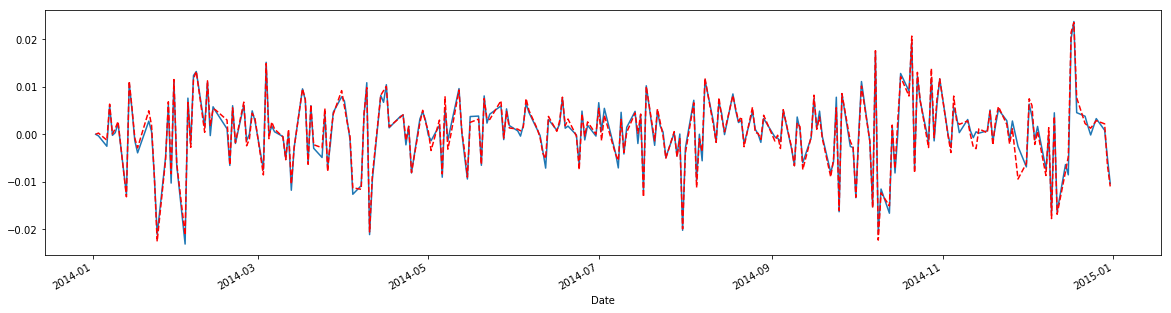

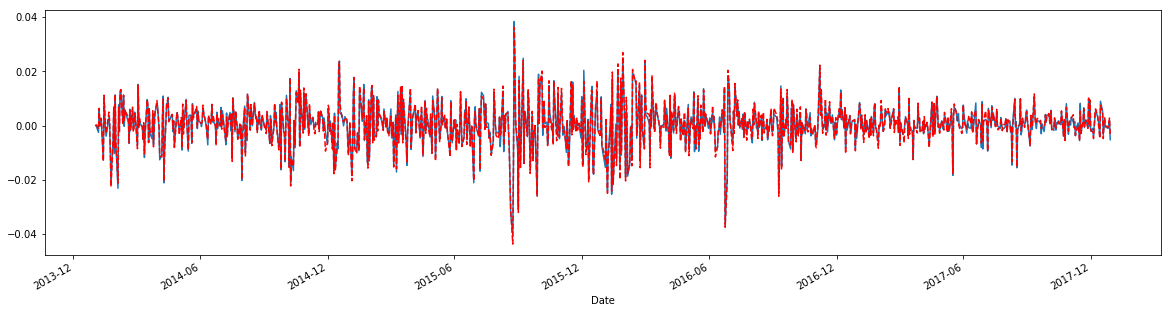

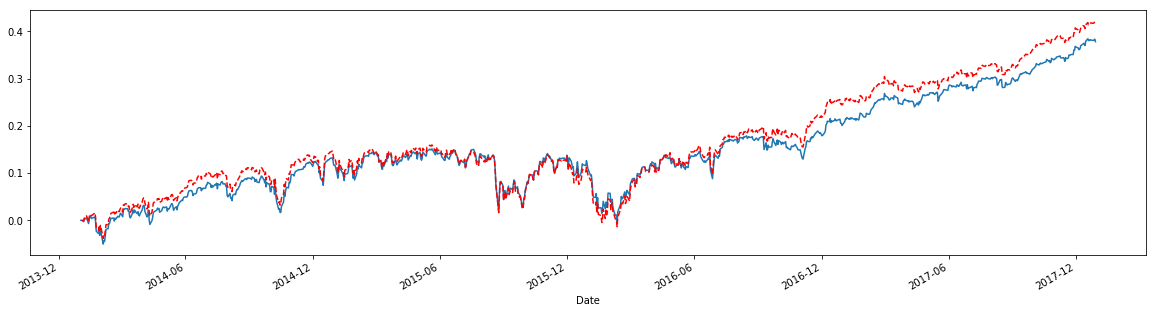

In [237]:
print('Correlation is %.6f')%(np.corrcoef(GSPC_log_test.loc['2014','Daily_Return'].values.flatten(),
                                          portfolio_test_fun.loc['2014','Daily_Return'].values.flatten())[0,1])
print('Correlation is %.6f')%(np.corrcoef(GSPC_log_test.loc[:,'Daily_Return'].values.flatten(),
                                          portfolio_test_fun.loc[:,'Daily_Return'].values.flatten())[0,1])
GSPC_log_test.loc['2014','Daily_Return'].plot(figsize=(20,5))
portfolio_test_fun.loc['2014','Daily_Return'].plot(figsize=(20,5),style='r--')
plt.show()
GSPC_log_test.loc[:,'Daily_Return'].plot(figsize=(20,5))
portfolio_test_fun.loc[:,'Daily_Return'].plot(figsize=(20,5),style='r--')
plt.show()
GSPC_log_test.loc[:,'Cumsum Daily_Return'].plot(figsize=(20,5),)
portfolio_test_fun.loc[:,'Cumsum Daily_Return'].plot(figsize=(20,5),style='r--')
plt.show()

#### let rebalance using normal linear regression

In [325]:
GSPC_log_train_fun_rebal = GSPC_log.loc["2008": "2016"].copy()
All_ETFs_log_train_fun_rebal = All_ETFs_log.loc["2008": "2016", index_of_etfs].copy()

In [326]:
LR_rebal = LinearRegression()
LR_rebal.fit(All_ETFs_log_train_fun_rebal,GSPC_log_train_fun_rebal)
LR_rebal_residual = GSPC_log_train_fun_rebal.values.flatten() - LR_rebal.predict(All_ETFs_log_train_fun_rebal).flatten()
print '\nthe alpha in linear balance is %s and the P-value for ADF is %s'%(0.000101, ADF(LR_rebal_residual.flatten())[1])
print 'with in all coefficients, there are %s ETFs are positive'%(np.sum(LR_rebal.coef_>0))
print 'with in all coefficients, there are %s ETFs are negative'%(np.sum(LR_rebal.coef_<0))
print 'with in all coefficients, there are %s ETFs equal to 0'%(np.sum(LR_rebal.coef_ ==0))

 


the alpha in linear balance is 0.000101 and the P-value for ADF is 0.0328726608378
with in all coefficients, there are 9 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 0 ETFs equal to 0


In [327]:
LR_rebal.coef_.flatten()>0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [348]:
new_x = All_ETFs_log.loc[:,LR_rebal.coef_.flatten()>0]

In [329]:
LR_rebal_new = LinearRegression()
LR_rebal_new.fit(new_x,GSPC_log_train_fun_rebal)
LR_rebal_new_residual = GSPC_log_train_fun_rebal.values.flatten() - LR_rebal_new.predict(new_x).flatten()
print '\nthe alpha in linear balance is %s and the P-value for ADF is %s'%(0.000101, ADF(LR_rebal_new_residual.flatten())[1])
print 'with in all coefficients, there are %s ETFs are positive'%(np.sum(LR_rebal_new.coef_>0))
print 'with in all coefficients, there are %s ETFs are negative'%(np.sum(LR_rebal_new.coef_<0))
print 'with in all coefficients, there are %s ETFs equal to 0'%(np.sum(LR_rebal_new.coef_ ==0))


the alpha in linear balance is 0.000101 and the P-value for ADF is 0.0328726608378
with in all coefficients, there are 9 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
with in all coefficients, there are 0 ETFs equal to 0


In [334]:
LR_rebal_new.coef_

array([[ 0.1999421 ,  0.25159283,  0.08362025,  0.02257944,  0.11626717,
         0.01964689,  0.07096596,  0.05075243,  0.09952006]])

In [349]:
portfolio_test = pd.DataFrame(0,columns=['portf_forest','Daily_Return'] ,
                                  index=GSPC_log.loc['2014':'2017'].index)  # this is to store the test data from ETFs
coefficients= LR_rebal_new.coef_.copy()
nonzero_coeff  = coefficients.copy()
nonzero_coeff = nonzero_coeff/nonzero_coeff.sum()
portfolio_test_fun['portf_forest'] = new_x.dot(nonzero_coeff.flatten()).copy()
portfolio_test_fun['Daily_Return'] = portfolio_test_fun['portf_forest'].diff()
portfolio_test_fun['Cumsum Daily_Return'] = portfolio_test_fun['Daily_Return'].cumsum()
portfolio_test_fun.iloc[0,1] = 0

Correlation is 0.891217


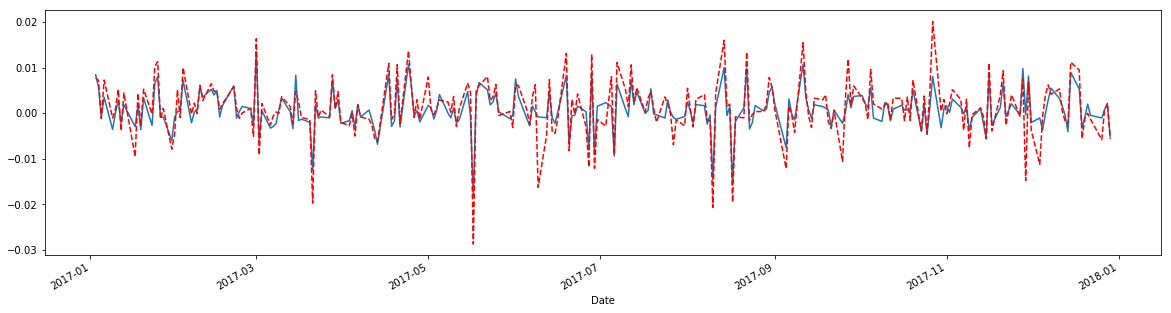

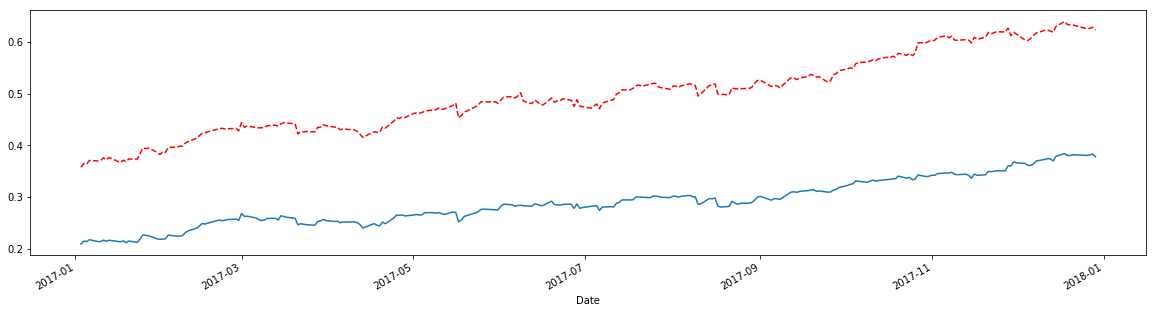

In [350]:
print('Correlation is %.6f')%(np.corrcoef(GSPC_log_test.loc['2017','Daily_Return'].values.flatten(),
                                          portfolio_test_fun.loc['2017','Daily_Return'].values.flatten())[0,1])
GSPC_log_test.loc['2017','Daily_Return'].plot(figsize=(20,5))
portfolio_test_fun.loc['2017','Daily_Return'].plot(figsize=(20,5),style='r--')
plt.show()
GSPC_log_test.loc['2017','Cumsum Daily_Return'].plot(figsize=(20,5),)
portfolio_test_fun.loc['2017','Cumsum Daily_Return'].plot(figsize=(20,5),style='r--')
plt.show()

In [11]:
GSPC_log_train = GSPC_log.loc["2008-01": "2013-12-31"].copy()
GSPC_log_test = GSPC_log.loc["2014-01-01": "2017-12-31"].copy()
All_ETFs_log_train = All_ETFs_log.loc["2008-01": "2013-12-31"].copy()
All_ETFs_log_test = All_ETFs_log.loc["2014-01-01": "2017-12-31"].copy()

## GSPC No rebalance

In [378]:
def GSPC_no_balance(alpha_input = 0.000001): 
    
    GSPC_log_train = GSPC_log.loc["2008-01": "2013-12-31"].copy()
    
    All_ETFs_log_train = All_ETFs_log.loc["2008-01": "2013-12-31"].copy()

    portfolio_test = pd.DataFrame(0,columns=['portf_forest','portfolio_test_intercept'] ,index=GSPC_log.loc['2014':'2017'].index)  # this is to store the test data from ETFs

    LR_lasso_year = Lasso(alpha=alpha_input, fit_intercept=True,normalize=None,random_state=123456)

    LR_lasso_year.fit(All_ETFs_log_train,GSPC_log_train[['Adj Close']])
    print('\n\n ')
    print('for LASSO alpha',LR_lasso_year.alpha)
    print('original coeff greater than 0 is ',np.sum(LR_lasso_year.coef_ > 0 ))
    print('original coeff leass than 0 is ' ,np.sum(LR_lasso_year.coef_ < 0 ))
    print('original coeff equal to 0 is ',np.sum(LR_lasso_year.coef_ == 0) )

    index_of_etfs = LR_lasso_year.coef_ > 0 # these etfs are our portfolio etfs, we need those to build the portfolio,and to rebalance

    All_ETFs_log_year = All_ETFs_log.loc[: , index_of_etfs] .copy()  # this contains all the etfs we used to build portfolio

    coefficients= LR_lasso_year.coef_.copy()

    nonzero_coeff  = coefficients[~(coefficients==0)].copy()

    nonzero_coeff = nonzero_coeff/nonzero_coeff.sum()

    portfolio_test['portf_forest'] = All_ETFs_log_year.dot(nonzero_coeff).copy()

    portfolio_test['portfolio_test_intercept'] = portfolio_test['portf_forest']+LR_lasso_year.intercept_


#     plt.figure(figsize=(25,8))
#     plt.plot(GSPC_log_test.index,GSPC_log_test['Adj Close'], 'r-', label='Real data' )
#     plt.plot(GSPC_log_test.index,portfolio_test['portfolio_test_intercept'].loc["2014-01-01": "2017-12-31"], 'g-', label='No balance Portfolio' )
#     plt.legend(loc='upper left')
#     plt.title('Comparison between real S&P500 and portfolio constructed on test data')
#     plt.show()

    portfolio_test['Daily_Return'] = portfolio_test['portf_forest'].diff()
    portfolio_test['Daily_Return'][0] = 0
    portfolio_test['Cumsum Daily_Return'] = portfolio_test['Daily_Return'].cumsum()

#     portfolio_test['Daily_Return'].plot(kind='line',figsize=(20,5),label = 'annual rebalance portfolio cumsum return',style='r-')
#     GSPC_log_test['Daily_Return'].loc["2014-01-01": "2017-12-31"].plot(kind='line',figsize=(20,5),label = 'GSPC cumsum return',style='g-')
#     plt.legend(loc='upper left')
#     plt.xticks( pd.date_range(start='2014-1-01', end='2018-01-01', freq = 'M'))
#     plt.title('Cumsum Return GSPC and Portfolio')
#     plt.show()

    Track_error_annual = portfolio_test['Daily_Return'] - GSPC_log_test['Daily_Return']

    print('annual Tracking Error Variance is %.8f') %(np.var(Track_error_annual))

    print('Sum of square Tracking Error is %.8f') %(np.sum(Track_error_annual**2))

    print('Information ratio of the annual portfolio is %.3f')%(np.mean(Track_error_annual)/np.std(Track_error_annual))

    print('No rebalance Correlation coefficient between portfolio and GSPC is %.6f')%(
        np.corrcoef(GSPC_log_test['Daily_Return'].values.flatten(),portfolio_test['Daily_Return'].values.flatten())[0,1])


In [379]:
# for i in stationary_alpha:
#     GSPC_no_balance(i)
GSPC_no_balance(alpha_input=0.000101)



 
('for LASSO alpha', 0.000101)
('original coeff greater than 0 is ', 10)
('original coeff leass than 0 is ', 0)
('original coeff equal to 0 is ', 41)
annual Tracking Error Variance is 0.00000181
Sum of square Tracking Error is 0.00182668
Information ratio of the annual portfolio is 0.029
No rebalance Correlation coefficient between portfolio and GSPC is 0.985541


In [377]:
GSPC_log_train = GSPC_log.loc["2008-01": "2013-12-31"].copy()

All_ETFs_log_train = All_ETFs_log.loc["2008-01": "2013-12-31"].copy()

portfolio_test_no = pd.DataFrame(0,columns=['portf_forest','portfolio_test_intercept'] ,index=GSPC_log.loc['2014':'2017'].index)  # this is to store the test data from ETFs

LR_lasso_no = Lasso(alpha=0.000101, fit_intercept=True,normalize=None,random_state=123456)

LR_lasso_no.fit(All_ETFs_log_train,GSPC_log_train[['Adj Close']])
print('\n\n ')
print('for LASSO alpha',LR_lasso_no.alpha)
print('original coeff greater than 0 is ',np.sum(LR_lasso_no.coef_ > 0 ))
print('original coeff leass than 0 is ' ,np.sum(LR_lasso_no.coef_ < 0 ))
print('original coeff equal to 0 is ',np.sum(LR_lasso_no.coef_ == 0) )

index_of_etfs = LR_lasso_no.coef_ > 0 # these etfs are our portfolio etfs, we need those to build the portfolio,and to rebalance

All_ETFs_log_no = All_ETFs_log.loc[: , index_of_etfs] .copy()  # this contains all the etfs we used to build portfolio

coefficients= LR_lasso_no.coef_.copy()

nonzero_coeff  = coefficients[~(coefficients==0)].copy()

nonzero_coeff = nonzero_coeff/nonzero_coeff.sum()

portfolio_test_no['portf_forest'] = All_ETFs_log_no.dot(nonzero_coeff).copy()

portfolio_test_no['portfolio_test_intercept'] = portfolio_test_no['portf_forest']+LR_lasso_no.intercept_


#     plt.figure(figsize=(25,8))
#     plt.plot(GSPC_log_test.index,GSPC_log_test['Adj Close'], 'r-', label='Real data' )
#     plt.plot(GSPC_log_test.index,portfolio_test['portfolio_test_intercept'].loc["2014-01-01": "2017-12-31"], 'g-', label='No balance Portfolio' )
#     plt.legend(loc='upper left')
#     plt.title('Comparison between real S&P500 and portfolio constructed on test data')
#     plt.show()

portfolio_test_no['Daily_Return'] = portfolio_test_no['portf_forest'].diff()
portfolio_test_no['Daily_Return'][0] = 0
portfolio_test_no['Cumsum Daily_Return'] = portfolio_test_no['Daily_Return'].cumsum()

#     portfolio_test['Daily_Return'].plot(kind='line',figsize=(20,5),label = 'annual rebalance portfolio cumsum return',style='r-')
#     GSPC_log_test['Daily_Return'].loc["2014-01-01": "2017-12-31"].plot(kind='line',figsize=(20,5),label = 'GSPC cumsum return',style='g-')
#     plt.legend(loc='upper left')
#     plt.xticks( pd.date_range(start='2014-1-01', end='2018-01-01', freq = 'M'))
#     plt.title('Cumsum Return GSPC and Portfolio')
#     plt.show()

Track_error_no = portfolio_test_no['Daily_Return'] - GSPC_log_test['Daily_Return']

print('annual Tracking Error Variance is %.8f') %(np.var(Track_error_no))

print('Sum of square Tracking Error is %.8f') %(np.sum(Track_error_no**2))

print('Information ratio of the annual portfolio is %.3f')%(np.mean(Track_error_no)/np.std(Track_error_no))

print('No rebalance Correlation coefficient between portfolio and GSPC is %.6f')%(
    np.corrcoef(GSPC_log_test['Daily_Return'].values.flatten(),portfolio_test_no['Daily_Return'].values.flatten())[0,1])




 
('for LASSO alpha', 0.000101)
('original coeff greater than 0 is ', 10)
('original coeff leass than 0 is ', 0)
('original coeff equal to 0 is ', 41)
annual Tracking Error Variance is 0.00000181
Sum of square Tracking Error is 0.00182668
Information ratio of the annual portfolio is 0.029
No rebalance Correlation coefficient between portfolio and GSPC is 0.985541


In [404]:
for i in range(2014,2018):
    print 'for ',i
    print('No rebalance Correlation coefficient between portfolio and GSPC is %.6f')%(
        np.corrcoef(GSPC_log_test.loc[str(i),'Daily_Return'].values.flatten(),portfolio_test_no.loc[str(i),'Daily_Return'].values.flatten())[0,1])


for  2014
No rebalance Correlation coefficient between portfolio and GSPC is 0.987694
for  2015
No rebalance Correlation coefficient between portfolio and GSPC is 0.990411
for  2016
No rebalance Correlation coefficient between portfolio and GSPC is 0.984325
for  2017
No rebalance Correlation coefficient between portfolio and GSPC is 0.963514


## yearly rebalance 

In [468]:
GSPC_log_train = GSPC_log.loc["2008-01": "2013-12-31"].copy()

All_ETFs_log_train = All_ETFs_log.loc["2008-01": "2013-12-31"].copy()

portfolio_test = pd.DataFrame(0,columns=['portf_forest','portfolio_test_intercept'] ,index=GSPC_log.loc['2014':'2017'].index)  # this is to store the test data from ETFs

LR_lasso_year = Lasso(alpha=0.000131, fit_intercept=True,normalize=None,random_state=123456)

LR_lasso_year.fit(All_ETFs_log_train,GSPC_log_train[['Adj Close']])

print('original coeff greater than 0 is ',np.sum(LR_lasso_year.coef_ > 0 ))
print('original coeff leass than 0 is ' ,np.sum(LR_lasso_year.coef_ < 0 ))
print('original coeff equal to 0 is ',np.sum(LR_lasso_year.coef_ == 0) )

index_of_etfs = LR_lasso_year.coef_ > 0 # these etfs are our portfolio etfs, we need those to build the portfolio,and to rebalance

All_ETFs_log_year = All_ETFs_log.loc[: , index_of_etfs] .copy()  # this contains all the etfs we used to build portfolio

coefficients= LR_lasso_year.coef_.copy()

nonzero_coeff  = coefficients[~(coefficients==0)].copy()

nonzero_coeff = nonzero_coeff/nonzero_coeff.sum()

portfolio_test.loc['2014','portf_forest'] = All_ETFs_log_year.dot(nonzero_coeff).loc['2014'].copy()

portfolio_test.loc['2014','portfolio_test_intercept'] = portfolio_test.loc['2014','portf_forest']+LR_lasso_year.intercept_

j = 1

for i in pd.date_range(start='2014', end='2017', freq='A'):
    
    Lasso_Model = Lasso(alpha=0.00000001 , fit_intercept=True,normalize=None,positive=True,random_state=123456)
    
    All_ETFs_log_train = All_ETFs_log_year.loc['2008': i].copy()
   
    GSPC_log_train = GSPC_log.loc['2008': i].copy()
    
    Lasso_Model.fit(All_ETFs_log_train,GSPC_log_train[['Adj Close']])
    
    print('\n\nfor range in 2008 to'+str(i))
    
    print('number of coeff greater than 0 is ',np.sum(Lasso_Model.coef_ > 0 ))
   
    print('number of coeff leass than 0 is ' ,np.sum(Lasso_Model.coef_ < 0 ))
    
    print('number of coeff equal to 0 is ',np.sum(Lasso_Model.coef_ == 0) )
    
    Lasso_Model_residual = GSPC_log_train[['Adj Close']].values.flatten() - Lasso_Model.predict(All_ETFs_log_train)
   
    check_for_stationarity(Lasso_Model_residual.flatten(),cutoff=0.05)
   
    coefficients= Lasso_Model.coef_.copy()

    coefficients = coefficients/coefficients.sum()
    
    portfolio_test.loc[str(2014+j),'portf_forest'] = All_ETFs_log_year.dot(coefficients).loc[str(2014+j)].copy()
    
    portfolio_test.loc[str(2014+j),'portfolio_test_intercept'] = portfolio_test.loc[str(2014+j),'portf_forest']+Lasso_Model.intercept_

    
    j+=1
    
    print('%sth loop is good'%(j))

('original coeff greater than 0 is ', 9)
('original coeff leass than 0 is ', 0)
('original coeff equal to 0 is ', 42)


for range in 2008 to2014-12-31 00:00:00
('number of coeff greater than 0 is ', 8)
('number of coeff leass than 0 is ', 0)
('number of coeff equal to 0 is ', 1)
p-value = 5.97386805553e-05 The series  is likely stationary.
2th loop is good


for range in 2008 to2015-12-31 00:00:00
('number of coeff greater than 0 is ', 8)
('number of coeff leass than 0 is ', 0)
('number of coeff equal to 0 is ', 1)
p-value = 0.000411771513856 The series  is likely stationary.
3th loop is good


for range in 2008 to2016-12-31 00:00:00
('number of coeff greater than 0 is ', 9)
('number of coeff leass than 0 is ', 0)
('number of coeff equal to 0 is ', 0)
p-value = 0.00251863312447 The series  is likely stationary.
4th loop is good


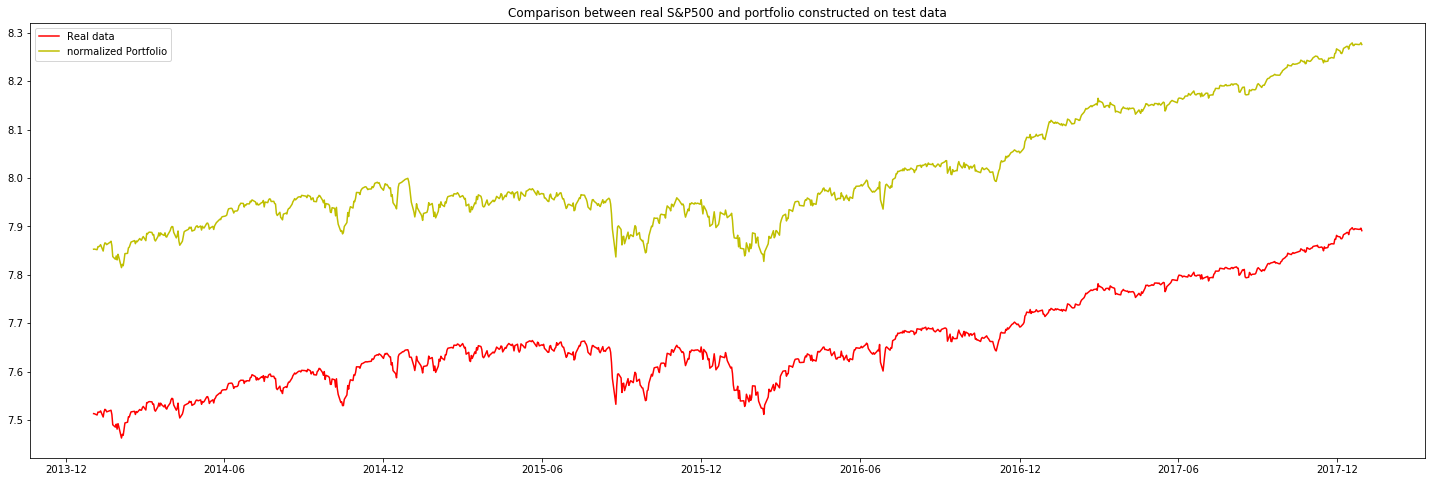

In [469]:
plt.figure(figsize=(25,8))
plt.plot(GSPC_log_test.index,GSPC_log_test['Adj Close'], 'r-', label='Real data' )
plt.plot(GSPC_log_test.index,portfolio_test['portfolio_test_intercept'].loc["2014-01-01": "2017-12-31"], 'y-', label='normalized Portfolio' )
#plt.plot(All_ETFs_log_test.index,LR_lasso_1.predict(All_ETFs_log_test), 'b-', label='Portfolio data by regular coefficient' )
plt.legend(loc='upper left')
plt.title('Comparison between real S&P500 and portfolio constructed on test data')
plt.show()

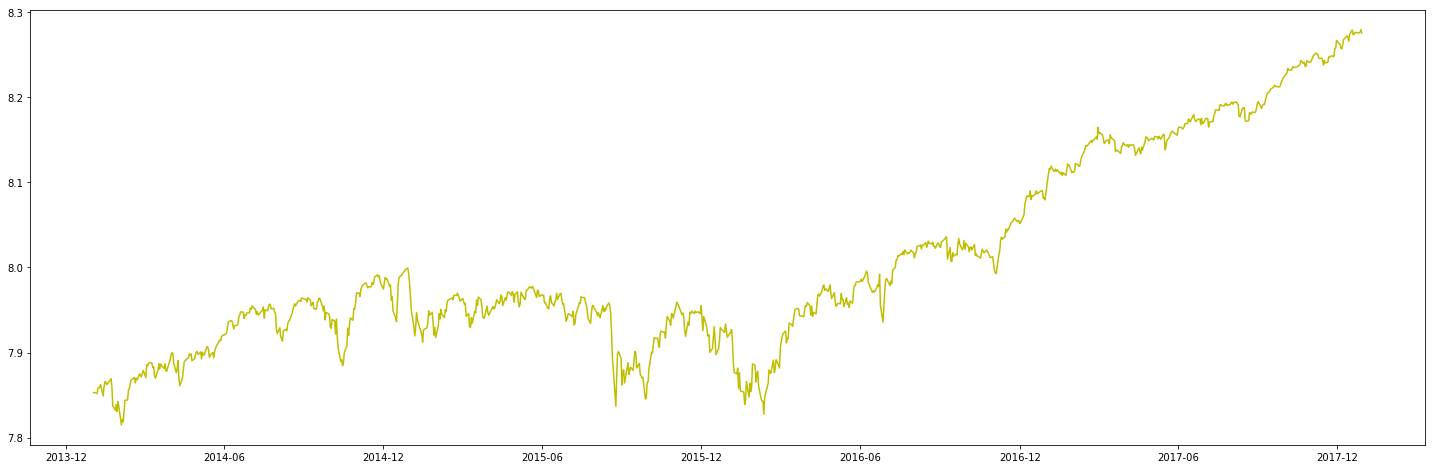

In [470]:
plt.figure(figsize=(25,8))
plt.plot(GSPC_log_test.index,portfolio_test['portfolio_test_intercept'].loc["2014-01-01": "2017-12-31"], 'y-', label='normalized Portfolio' )
plt.show()

In [471]:
portfolio_test['Daily_Return'] = portfolio_test['portf_forest'].diff()
portfolio_test['Daily_Return'][0] = 0
portfolio_test['Cumsum Daily_Return'] = portfolio_test['Daily_Return'].cumsum()

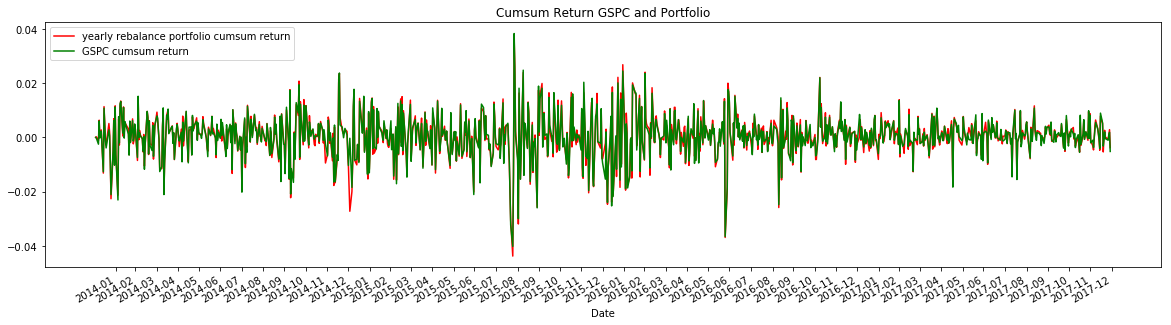

In [472]:
portfolio_test['Daily_Return'].loc["2014-01-01": "2017-12-31"].plot(kind='line',figsize=(20,5),label = 'yearly rebalance portfolio cumsum return',style='r-')
GSPC_log_test['Daily_Return'].loc["2014-01-01": "2017-12-31"].plot(kind='line',figsize=(20,5),label = 'GSPC cumsum return',style='g-')
plt.legend(loc='upper left')
plt.xticks( pd.date_range(start='2014-1-01', end='2018-01-01', freq = 'M'))
plt.title('Cumsum Return GSPC and Portfolio')
plt.show()

In [473]:
Track_error_year = portfolio_test['Daily_Return'] - GSPC_log_test['Daily_Return']

In [474]:
print('Tracking Error Variance is %.6f') %(np.var(Track_error_year))

Tracking Error Variance is 0.000002


In [475]:
np.sum(Track_error_year**2)

0.0024413984606172774

In [476]:
print('Information ratio of the portfolio is %.3f')%(np.mean(Track_error_year)/np.std(Track_error_year))

Information ratio of the portfolio is 0.007


In [477]:
print('Yearly  Correlation coefficient between portfolio and SP500 is %.6f')%(
    np.corrcoef(GSPC_log_test.loc[:,'Daily_Return'].values.flatten(),portfolio_test.loc[:,'Daily_Return'].values.flatten())[0,1])

Yearly  Correlation coefficient between portfolio and SP500 is 0.980115


In [478]:
portfolio_test.head()

,portf_forest,portfolio_test_intercept,Daily_Return,Cumsum Daily_Return
Date,,,,
2014-01-02,3.998335,7.852877,0.000000,0.000000
2014-01-03,3.998543,7.853085,0.000208,0.000208
2014-01-06,3.997295,7.851837,-0.001248,-0.001040
2014-01-07,4.003630,7.858172,0.006335,0.005295
2014-01-08,4.003741,7.858283,0.000111,0.005406


In [479]:
print('year rebalance 2017 Correlation coefficient between portfolio and GSPC is %.6f')%(
    np.corrcoef(GSPC_log_test.loc['2016-01-05':'2016-12-30','Daily_Return'].values.flatten(),
                portfolio_test.loc['2016-01-05':'2016-12-30','Daily_Return'].values.flatten())[0,1])


year rebalance 2017 Correlation coefficient between portfolio and GSPC is 0.989935


In [480]:
portfolio_test['Daily_Return'].loc['2016'].tail()

Date
2016-12-23    0.001652
2016-12-27    0.002146
2016-12-28   -0.009214
2016-12-29    0.000869
2016-12-30   -0.002610
Name: Daily_Return, dtype: float64

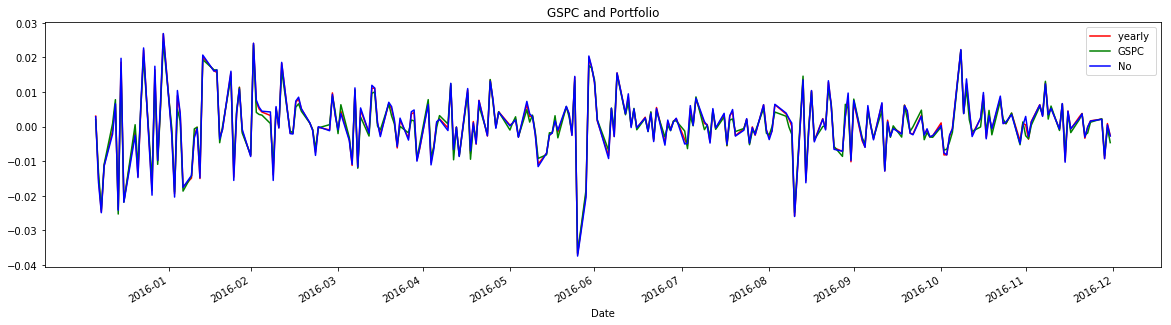

In [481]:
portfolio_test['Daily_Return'].loc['2016-01-05':'20161231'].plot(kind='line',figsize=(20,5),
                                                               label = 'yearly ',style='r-')
GSPC_log_test['Daily_Return'].loc['2016-01-05':'20161231'].plot(kind='line',figsize=(20,5),label = 'GSPC',style='g-')
portfolio_test_no['Daily_Return'].loc['2016-01-05':'20161231'].plot(kind='line',figsize=(20,5),
                                                                  label = 'No',style='b-')
plt.legend(loc='upper right')
plt.xticks( pd.date_range(start='2016-1-01', end='2017-01-01', freq = 'M'))
plt.title('GSPC and Portfolio')
plt.show()

## semi-annual rebalance

In [24]:
GSPC_log_train = GSPC_log.loc["2008-01": "2013-12-31"].copy()

All_ETFs_log_train = All_ETFs_log.loc["2008-01": "2013-12-31"].copy()

portfolio_test_semi = pd.DataFrame(0,columns=['portf_forest','portfolio_test_intercept'] ,index=GSPC_log.loc['2014':'2017'].index)  # this is to store the test data from ETFs

LR_lasso_semi = Lasso(alpha=0.000131, fit_intercept=True,normalize=None,random_state=123456)

LR_lasso_semi.fit(All_ETFs_log_train,GSPC_log_train[['Adj Close']])

print('original coeff greater than 0 is ',np.sum(LR_lasso_semi.coef_ > 0 ))
print('original coeff leass than 0 is ' ,np.sum(LR_lasso_semi.coef_ < 0 ))
print('original coeff equal to 0 is ',np.sum(LR_lasso_semi.coef_ == 0) )

index_of_etfs = LR_lasso_semi.coef_ > 0 # these etfs are our portfolio etfs, we need those to build the portfolio,and to rebalance

All_ETFs_log_semi = All_ETFs_log.loc[: , index_of_etfs] .copy()  # this contains all the etfs we used to build portfolio

coefficients= LR_lasso_semi.coef_.copy()

nonzero_coeff  = coefficients[~(coefficients==0)].copy()

nonzero_coeff = nonzero_coeff/nonzero_coeff.sum()

portfolio_test_semi.loc['20140101':'20140630','portf_forest'] = All_ETFs_log_semi.dot(nonzero_coeff).loc['20140101':'20140630'].copy()

portfolio_test_semi.loc['20140101':'20140630','portfolio_test_intercept'] = portfolio_test_semi.loc['20140101':'20140630','portf_forest']+LR_lasso_semi.intercept_

j = 0

semi_dates_begin = pd.date_range(start='2014-07-01', end='2017-07-01', freq='6MS')

semi_dates_end = pd.date_range(start='2014-06-30', end='2017-12-31', freq='6M',closed='right')

for i in pd.date_range(start='2013-12-31', end='2017-06-30', freq='6M',closed='right'):
    
    Lasso_Model = Lasso(alpha=0.0001 , fit_intercept=True,normalize=None,positive =True,random_state=123456)
    
    All_ETFs_log_train = All_ETFs_log_semi.loc['2008': i].copy()
   
    GSPC_log_train = GSPC_log.loc['2008': i].copy()
    
    Lasso_Model.fit(All_ETFs_log_train,GSPC_log_train[['Adj Close']])
    
    print('\n\nfor range in 2008 to'+str(i))
    
    print('number of coeff greater than 0 is ',np.sum(Lasso_Model.coef_ > 0 ))
   
    print('number of coeff leass than 0 is ' ,np.sum(Lasso_Model.coef_ < 0 ))
    
    print('number of coeff equal to 0 is ',np.sum(Lasso_Model.coef_ == 0) )
    
    Lasso_Model_residual = GSPC_log_train[['Adj Close']].values.flatten() - Lasso_Model.predict(All_ETFs_log_train)
   
    check_for_stationarity(Lasso_Model_residual.flatten(),cutoff=0.05)
   
    coefficients= Lasso_Model.coef_.copy()

    coefficients = coefficients/coefficients.sum()
    
    portfolio_test_semi.loc[semi_dates_begin[j]:semi_dates_end[j],'portf_forest'] = All_ETFs_log_semi.dot(coefficients).loc[semi_dates_begin[j]:semi_dates_end[j]].copy()
    
    portfolio_test_semi.loc[semi_dates_begin[j]:semi_dates_end[j],'portfolio_test_intercept'] = portfolio_test_semi.loc[semi_dates_begin[j]:semi_dates_end[j],'portf_forest']+Lasso_Model.intercept_

    
    j+=1
    
    print('%sth loop is good'%(j))

('original coeff greater than 0 is ', 9)
('original coeff leass than 0 is ', 0)
('original coeff equal to 0 is ', 42)


for range in 2008 to2014-06-30 00:00:00
('number of coeff greater than 0 is ', 9)
('number of coeff leass than 0 is ', 0)
('number of coeff equal to 0 is ', 0)
p-value = 5.37376080836e-05 The series  is likely stationary.
1th loop is good


for range in 2008 to2014-12-31 00:00:00
('number of coeff greater than 0 is ', 9)
('number of coeff leass than 0 is ', 0)
('number of coeff equal to 0 is ', 0)
p-value = 7.80266383269e-05 The series  is likely stationary.
2th loop is good


for range in 2008 to2015-06-30 00:00:00
('number of coeff greater than 0 is ', 9)
('number of coeff leass than 0 is ', 0)
('number of coeff equal to 0 is ', 0)
p-value = 0.000402777479897 The series  is likely stationary.
3th loop is good


for range in 2008 to2015-12-31 00:00:00
('number of coeff greater than 0 is ', 9)
('number of coeff leass than 0 is ', 0)
('number of coeff equal to 0 is ', 

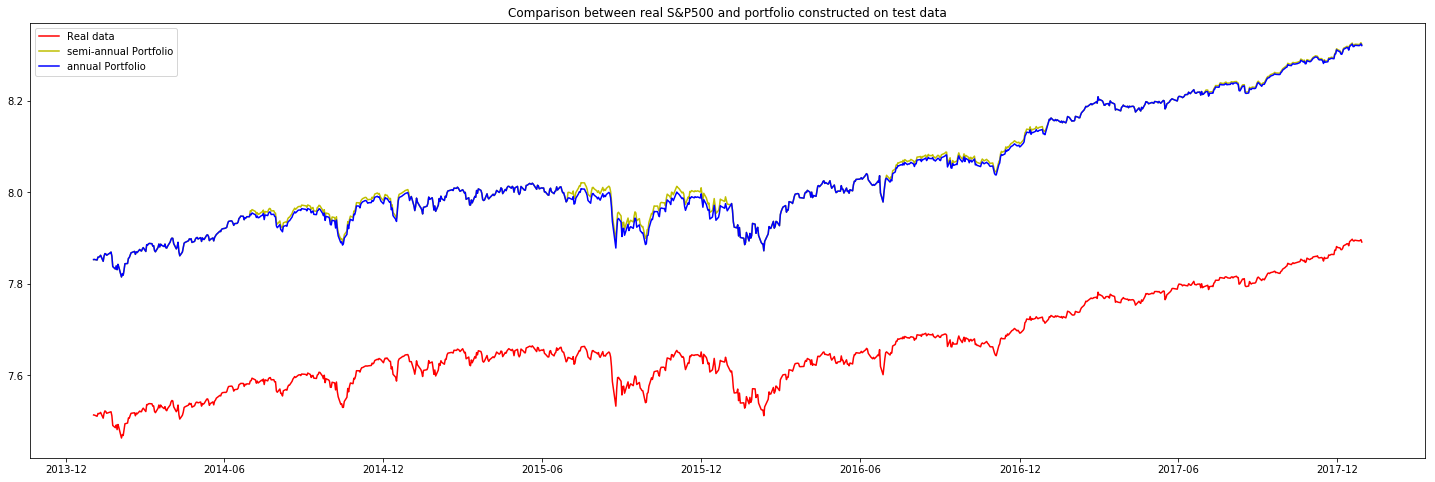

In [25]:
plt.figure(figsize=(25,8))
plt.plot(GSPC_log_test.index,GSPC_log_test['Adj Close'], 'r-', label='Real data' )
plt.plot(GSPC_log_test.index,portfolio_test_semi['portfolio_test_intercept'].loc["2014-01-01": "2017-12-31"], 'y-', label='semi-annual Portfolio' )
plt.plot(GSPC_log_test.index,portfolio_test['portfolio_test_intercept'].loc["2014-01-01": "2017-12-31"], 'b-', label='annual Portfolio' )
plt.legend(loc='upper left')
plt.title('Comparison between real S&P500 and portfolio constructed on test data')
plt.show()

In [26]:
portfolio_test_semi['Daily_Return'] = portfolio_test_semi['portf_forest'].diff()
portfolio_test_semi['Daily_Return'][0] = 0
portfolio_test_semi['Cumsum Daily_Return'] = portfolio_test_semi['Daily_Return'].cumsum()

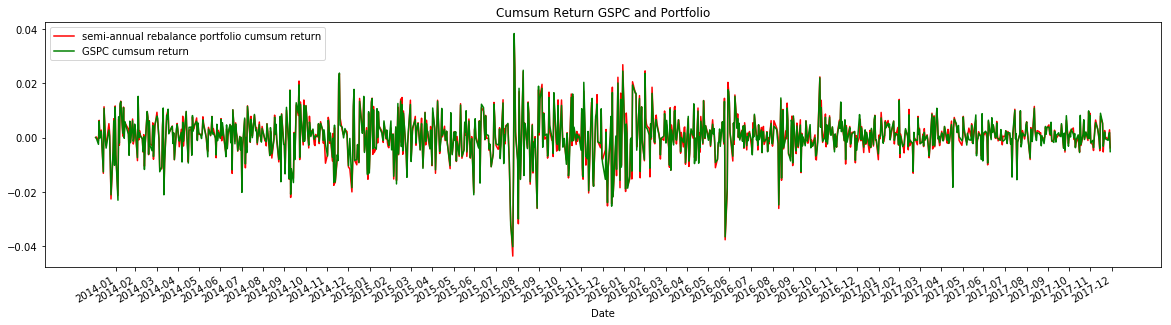

In [27]:
portfolio_test_semi['Daily_Return'].plot(kind='line',figsize=(20,5),label = 'semi-annual rebalance portfolio cumsum return',style='r-')
GSPC_log_test['Daily_Return'].loc["2014-01-01": "2017-12-31"].plot(kind='line',figsize=(20,5),label = 'GSPC cumsum return',style='g-')
plt.legend(loc='upper left')
plt.xticks( pd.date_range(start='2014-1-01', end='2018-01-01', freq = 'M'))
plt.title('Cumsum Return GSPC and Portfolio')
plt.show()

In [28]:
Track_error_semi = portfolio_test_semi['Daily_Return'] - GSPC_log_test['Daily_Return']

In [29]:
print('Semi_annual Tracking Error Variance is %.8f') %(np.var(Track_error_semi))

Semi_annual Tracking Error Variance is 0.00000170


In [30]:
np.sum(Track_error_semi**2)

0.0017113968370890379

In [31]:
print('Information ratio of the Semi-Annual portfolio is %.3f')%(np.mean(Track_error_semi)/np.std(Track_error_semi))

Information ratio of the Semi-Annual portfolio is 0.017


In [50]:
print('Semi annual  Correlation coefficient between portfolio and SP500 is %.6f')%(
    np.corrcoef(GSPC_log_test['Daily_Return'].values.flatten(),portfolio_test_semi['Daily_Return'].values.flatten())[0,1])

Semi annual  Correlation coefficient between portfolio and SP500 is 0.986182


## rebalance quarterly¶

In [41]:
GSPC_log_train = GSPC_log.loc["2008-01": "2013-12-31"].copy()

All_ETFs_log_train = All_ETFs_log.loc["2008-01": "2013-12-31"].copy()

portfolio_test_quarter = pd.DataFrame(0,columns=['portf_forest','portfolio_test_intercept'] ,index=GSPC_log.loc['2014':'2017'].index)  # this is to store the test data from ETFs

LR_lasso_quarter = Lasso(alpha=0.000131, fit_intercept=True,normalize=None,random_state=123456)

LR_lasso_quarter.fit(All_ETFs_log_train,GSPC_log_train[['Adj Close']])

print('original coeff greater than 0 is ',np.sum(LR_lasso_quarter.coef_ > 0 ))
print('original coeff leass than 0 is ' ,np.sum(LR_lasso_quarter.coef_ < 0 ))
print('original coeff equal to 0 is ',np.sum(LR_lasso_quarter.coef_ == 0) )

index_of_etfs = LR_lasso_quarter.coef_ > 0 # these etfs are our portfolio etfs, we need those to build the portfolio,and to rebalance

All_ETFs_log_quarter = All_ETFs_log.loc[: , index_of_etfs] .copy()  # this contains all the etfs we used to build portfolio

coefficients= LR_lasso_quarter.coef_.copy()

nonzero_coeff  = coefficients[~(coefficients==0)].copy()

nonzero_coeff = nonzero_coeff/nonzero_coeff.sum()

portfolio_test_quarter.loc['2014Q1','portf_forest'] = All_ETFs_log_quarter.dot(nonzero_coeff).loc['2014Q1'].copy()

portfolio_test_quarter.loc['2014Q1','portfolio_test_intercept'] = portfolio_test_quarter.loc['2014Q1','portf_forest']+LR_lasso_quarter.intercept_

quarter_dates = [str(i)+j for i in range(2014,2018) for j in ['Q1','Q2','Q3','Q4']]
 
j = 1

for i in pd.date_range(start='2014Q1', end='2017Q4', freq='Q'):   
    
    Lasso_Model = Lasso(alpha=0.0001 , fit_intercept=True,normalize=None,positive =True,random_state=123456)
    
    All_ETFs_log_train = All_ETFs_log_quarter.loc['2008': i].copy()
   
    GSPC_log_train = GSPC_log.loc['2008': i].copy()
    
    Lasso_Model.fit(All_ETFs_log_train,GSPC_log_train[['Adj Close']])
    
    print('\n\nfor range in 2008 to'+str(i))
    
    print('number of coeff greater than 0 is ',np.sum(Lasso_Model.coef_ > 0 ))
   
    print('number of coeff leass than 0 is ' ,np.sum(Lasso_Model.coef_ < 0 ))
    
    print('number of coeff equal to 0 is ',np.sum(Lasso_Model.coef_ == 0) )
    
    Lasso_Model_residual = GSPC_log_train[['Adj Close']].values.flatten() - Lasso_Model.predict(All_ETFs_log_train)
   
    check_for_stationarity(Lasso_Model_residual.flatten(),cutoff=0.05)
   
    coefficients= Lasso_Model.coef_.copy()

    coefficients = coefficients/coefficients.sum()
    
    portfolio_test_quarter.loc[quarter_dates[j],'portf_forest'] = All_ETFs_log_quarter.dot(coefficients).loc[quarter_dates[j]].copy()
    
    portfolio_test_quarter.loc[quarter_dates[j],'portfolio_test_intercept'] = portfolio_test_quarter.loc[quarter_dates[j],'portf_forest']+Lasso_Model.intercept_

    j+=1
    
    print('%sth loop is good'%(j))

('original coeff greater than 0 is ', 9)
('original coeff leass than 0 is ', 0)
('original coeff equal to 0 is ', 42)


for range in 2008 to2014-03-31 00:00:00
('number of coeff greater than 0 is ', 9)
('number of coeff leass than 0 is ', 0)
('number of coeff equal to 0 is ', 0)
p-value = 0.000102140817014 The series  is likely stationary.
2th loop is good


for range in 2008 to2014-06-30 00:00:00
('number of coeff greater than 0 is ', 9)
('number of coeff leass than 0 is ', 0)
('number of coeff equal to 0 is ', 0)
p-value = 5.37376080836e-05 The series  is likely stationary.
3th loop is good


for range in 2008 to2014-09-30 00:00:00
('number of coeff greater than 0 is ', 9)
('number of coeff leass than 0 is ', 0)
('number of coeff equal to 0 is ', 0)
p-value = 1.85561255827e-05 The series  is likely stationary.
4th loop is good


for range in 2008 to2014-12-31 00:00:00
('number of coeff greater than 0 is ', 9)
('number of coeff leass than 0 is ', 0)
('number of coeff equal to 0 is ', 

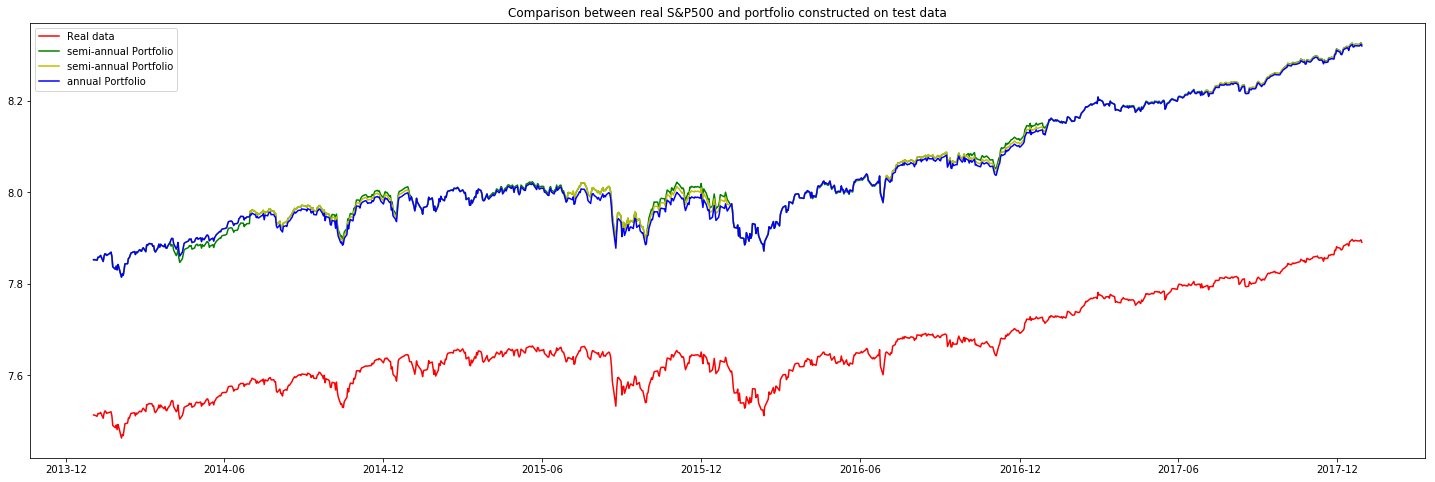

In [42]:
plt.figure(figsize=(25,8))
plt.plot(GSPC_log_test.index,GSPC_log_test['Adj Close'], 'r-', label='Real data' )
plt.plot(GSPC_log_test.index,portfolio_test_quarter['portfolio_test_intercept'].loc["2014-01-01": "2017-12-31"], 'g-', label='semi-annual Portfolio' )
plt.plot(GSPC_log_test.index,portfolio_test_semi['portfolio_test_intercept'].loc["2014-01-01": "2017-12-31"], 'y-', label='semi-annual Portfolio' )
plt.plot(GSPC_log_test.index,portfolio_test['portfolio_test_intercept'].loc["2014-01-01": "2017-12-31"], 'b-', label='annual Portfolio' )
plt.legend(loc='upper left')
plt.title('Comparison between real S&P500 and portfolio constructed on test data')
plt.show()

In [43]:
portfolio_test_quarter['Daily_Return'] = portfolio_test_quarter['portf_forest'].diff()
portfolio_test_quarter['Daily_Return'][0] = 0
portfolio_test_quarter['Cumsum Daily_Return'] = portfolio_test_quarter['Daily_Return'].cumsum()

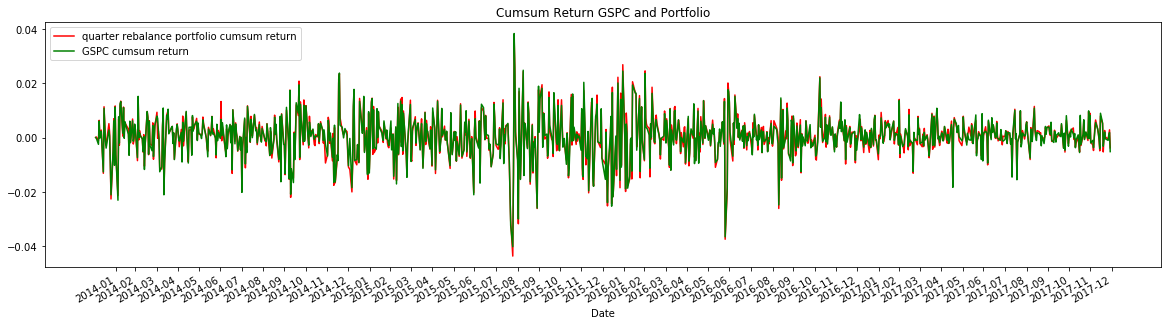

In [44]:
portfolio_test_quarter['Daily_Return'].plot(kind='line',figsize=(20,5),label = 'quarter rebalance portfolio cumsum return',style='r-')
GSPC_log_test['Daily_Return'].loc["2014-01-01": "2017-12-31"].plot(kind='line',figsize=(20,5),label = 'GSPC cumsum return',style='g-')
plt.legend(loc='upper left')
plt.xticks( pd.date_range(start='2014-1-01', end='2018-01-01', freq = 'M'))
plt.title('Cumsum Return GSPC and Portfolio')
plt.show()

In [45]:
Track_error_quarter = portfolio_test_quarter['Daily_Return'] - GSPC_log_test['Daily_Return']

In [46]:
print('quarter Tracking Error Variance is %.8f') %(np.var(Track_error_quarter))

quarter Tracking Error Variance is 0.00000172


In [47]:
np.sum(Track_error_quarter**2)

0.0017337918536213654

In [48]:
print('Information ratio of the quarter portfolio is %.3f')%(np.mean(Track_error_quarter)/np.std(Track_error_quarter))

Information ratio of the quarter portfolio is 0.017


In [49]:
print('Quarterly  Correlation coefficient between portfolio and SP500 is %.6f')%(
    np.corrcoef(GSPC_log_test['Daily_Return'].values.flatten(),portfolio_test_quarter['Daily_Return'].values.flatten())[0,1])

Quarterly  Correlation coefficient between portfolio and SP500 is 0.986112


In [13]:
def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = ADF(X)[1]
    if pvalue < cutoff:
        print 'p-value = ' + str(pvalue) + ' The series '  +' is likely stationary.'
        #return True
    else:
        print 'p-value = ' + str(pvalue) + ' The series '+' is likely non-stationary.'
        #return False

In [14]:
def check_for_stationarity_no_print(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = ADF(X)[1]
    if pvalue < cutoff:
        #print 'p-value = ' + str(pvalue) + ' The series '  +' is likely stationary.'
        return True
    else:
        #print 'p-value = ' + str(pvalue) + ' The series '+' is likely non-stationary.'
        return False